In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from numpy import nan
from sklearn.preprocessing import scale
pd.set_option("max.columns",300)
import os


from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn import datasets, linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge

os.getcwd()

'/Users/gniemiec/Documents/Kaggle/HousePrices'

In [2]:
def MyKFold(model,train_,k=5,model_name=""):
    
    train_t = train_.copy(deep = True)
    train_error = 0
    valid_error = 0
        
    train_t["bucket"] = np.mod(train_t.index,k)
    
    for i in range(0,k):
        #print(i)
        train_i = train_t[np.logical_not(train_t["bucket"]==i)]
        valid_i = train_t[train_t["bucket"]==i]
        
        train_y_i = train_i.SalePrice
        train_X_i = train_i.drop(['Id','SalePrice','bucket'],axis=1)
        
        valid_y_i = valid_i.SalePrice
        valid_X_i = valid_i.drop(['Id','SalePrice','bucket'],axis=1)
        
        #print (train_X_i.shape)
        #print (train_X_i.columns)
        #print (valid_X_i.shape)
        #print (valid_X_i.columns)
        
        model.fit(train_X_i, train_y_i)
    
        predicted_prices_train = model.predict(train_X_i)
        predicted_prices_valid = model.predict(valid_X_i)
        
        train_error_i = CalculateError(np.exp(train_y_i), np.exp(predicted_prices_train))
        valid_error_i = CalculateError(np.exp(valid_y_i), np.exp(predicted_prices_valid))

        if k < 10:
            print("ERROR {0} train {2}: {1}, Train (n): {3}".format(model_name,train_error_i,i,len(train_i)))
            print("ERROR {0} train {2}: {1}, Valid (n): {3}".format(model_name,valid_error_i,i,len(valid_i)))
        
        train_error += train_error_i
        valid_error += valid_error_i
        
    train_error = train_error / k
    valid_error = valid_error / k
        
    print("ERROR {} train avg {}:".format(model_name,train_error))
    print("ERROR {} valid avg {}:".format(model_name,valid_error))
       
    return train_error, valid_error

In [3]:
from sklearn.metrics import mean_squared_error
def CalculateError(y_true_,y_pred_):
    error_ = 0
    
    error_ = np.square(np.log(y_pred_ + 1) - np.log(y_true_ + 1)).mean() ** 0.5
    #error_ = np.square(y_pred_ - y_true_ ).mean() ** 0.5

    return error_

In [4]:
def AddPolynomialFeatures(df_, features_, maxorder_):
    for feature_ in features_:
        for order_ in range(2,maxorder_ + 1, 1):
            df_[feature_ + "^" + str(order_)] = df_[feature_]**order_
    return df_

In [5]:
def pct_rank_qcut(series, n):
    edges = pd.Series([float(i) / n for i in range(n + 1)])
    f = lambda x: (edges >= x).argmax()
    return series.rank(pct=1).apply(f)

In [6]:
# Read the data
train_source = pd.read_csv('./input/train.csv')
# Read the test data
test_source = pd.read_csv('./input/test_My.csv')
#test_source["SalePrice"] = 0

In [7]:
train_source.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:
test_source.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [9]:
#train_source.MSSubClass = train_source.MSSubClass.astype(str)
#test_source.MSSubClass = test_source.MSSubClass.astype(str)

In [10]:
def FeatureDirectPrediction (models_,col_,train_X_,test_X_,train_y_,test_y_,convert_to_dict = False,dict_=None, verbose = False):

    train_X = train_X_.copy(deep = True)
    test_X = test_X_.copy(deep = True)
    
    train_y = train_y_.copy(deep = True)
    test_y = test_y_.copy(deep = True)
    
    col = col_
    
    if convert_to_dict:
        train_X[col].replace(dict_ , inplace = True)
        test_X[col].replace(dict_ , inplace = True)
    
    train_error_avg = 0
    test_error_avg = 0
    i = 0
    
    for model_ in models_:

        model_.fit(train_X,train_y)

        train_y_hat = model_.predict(train_X)
        test_y_hat = model_.predict(test_X)


        model_name = model_.__class__.__name__
        train_error = CalculateError(train_y,train_y_hat)
        test_error = CalculateError(test_y,test_y_hat)

        if verbose:
            print (model_name)
            print ("Train error: ", train_error)
            print ("Test error: ", test_error)
        i = i + 1
        train_error_avg = train_error_avg + train_error
        test_error_avg = test_error_avg + test_error

    train_error_avg = train_error_avg / i
    test_error_avg = test_error_avg / i
    
    return train_error_avg, test_error_avg

In [11]:
def FeatureBinsPrediction (models_,col_,train_X_,test_X_,train_y_,test_y_,bins_ = 5,method_ = "cut", verbose = False):

    col = col_
    
    train_error_avg = 0
    test_error_avg = 0

    i = 0
    train_X = train_X_.copy(deep = True)
    test_X = test_X_.copy(deep = True)
    
    train_y = train_y_.copy(deep = True)
    test_y = test_y_.copy(deep = True)

    if method_ == "cut":
        train_X[col + '_bin'] = pd.cut(train_X[col], bins = bins_,labels = range(1,bins_+1,1))
        test_X[col + '_bin'] = pd.cut(test_X[col], bins = bins_,labels = range(1,bins_+1,1))

    if method_ == "qcut":

        #q = pct_rank_qcut(df.loss_percent, 10)

        #train_X[col + '_bin'] = pd.qcut(train_X[col], q = bins_,labels = range(1,bins_+1,1))
        #test_X[col + '_bin'] = pd.qcut(test_X[col], q = bins_,labels = range(1,bins_+1,1))

        train_X[col + '_bin'] = pct_rank_qcut(train_X[col], bins_)
        test_X[col + '_bin'] = pct_rank_qcut(test_X[col], bins_)
        
    if method_ != "dummies":
        train_X.drop([col], axis = 1, inplace = True)
        test_X.drop([col], axis = 1, inplace = True)

    cols_ohe = train_X.columns

    train_X.loc[:,"source_"] = "train"
    test_X.loc[:,"source_"] = "test"


    all_X = pd.concat([train_X,test_X])

    all_X_ohe = pd.get_dummies(all_X,columns = cols_ohe)


    train_X = all_X_ohe[all_X_ohe["source_"] == "train"].copy(deep = True)
    test_X = all_X_ohe[all_X_ohe["source_"] == "test"].copy(deep = True)


    train_X.drop(["source_"], axis = 1, inplace = True)
    test_X.drop(["source_"], axis = 1, inplace = True)

    #print (train_X)

    for model_ in models_:

        model_.fit(train_X,train_y)

        train_y_hat = model_.predict(train_X)
        test_y_hat = model_.predict(test_X)

        model_name = model_.__class__.__name__
        train_error = CalculateError(train_y,train_y_hat)
        test_error = CalculateError(test_y,test_y_hat)

        if verbose:
            print (model_name)
            print ("Train error: ", train_error)
            print ("Test error: ", test_error)
        i = i + 1
        train_error_avg = train_error_avg + train_error
        test_error_avg = test_error_avg + test_error

    train_error_avg = train_error_avg / i
    test_error_avg = test_error_avg / i
    
    return train_error_avg, test_error_avg

In [12]:
from IPython.display import display
if 1==0:
    index_ = 'Id'
    label_ = 'SalePrice'
    model1_ = linear_model.LinearRegression()
    model2_ = XGBRegressor(random_state = 42)
    model3_ = RandomForestRegressor(random_state = 42)
    models_ = [model1_,model2_,model3_]

    train_ = train_source
    test_ = test_source

    cols_ex_ = [index_,label_]

    for col in train_source.columns:
    #for col in ['LotArea','GrLivArea','OverallQual','Neighborhood']:
        if col not in cols_ex_:
            train_X = train_.loc[:,[col]]
            test_X = test_.loc[:,[col]]

            train_y = train_[label_]
            test_y = test_[label_]

            print('--------------------------------------------------------------')
            print (col,train_X[col].dtype)
            print('--------------------------------------------------------------')


            if train_X[col].dtype in [np.dtype('int64'),np.dtype('float'),np.dtype('uint8')]:

                train_X[col].fillna(0, inplace = True)
                test_X[col].fillna(0, inplace = True)

                fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[10,10])

                train_.plot.scatter(x=col,y="SalePrice",ax=axes[0,0])
                test_.plot.scatter(x=col,y="SalePrice",ax=axes[0,1])

                train_X.plot.hist(by = col,ax=axes[1,0])
                test_X.plot.hist(by = col,ax=axes[1,1])

                display(fig)

                plt.close()

                print("Direct prediction:" ,FeatureDirectPrediction (models_,col,train_X,test_X,train_y,test_y,convert_to_dict=False,dict_ = None, verbose = False))

                if len(train_X[col].unique()) > 10:

                    print("Bins:" ,FeatureBinsPrediction (models_,col,train_X,test_X,train_y,test_y,bins_ = 5,method_ = "cut", verbose = False))

                    print("Q Bins:" ,FeatureBinsPrediction (models_,col,train_X,test_X,train_y,test_y,bins_ = 5,method_= "qcut", verbose = False))
                else:
                    print("Dummies:" ,FeatureBinsPrediction (models_,col,train_X,test_X,train_y,test_y,bins_ = 0,method_= "dummies", verbose = False))


            if train_X[col].dtype in [np.dtype('object')]:

                train_X[col].fillna("None", inplace = True)
                test_X[col].fillna("None", inplace = True)

                fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[10,10])

                train_.boxplot(column="SalePrice", by=col,ax=axes[0,0])
                test_.boxplot(column="SalePrice", by=col,ax=axes[0,1])

                train_[col].value_counts(dropna=False).plot.bar(ax=axes[1,0])
                test_[col].value_counts(dropna=False).plot.bar(ax=axes[1,1])

                display(fig)
                plt.close()

                print("Dummies:" ,FeatureBinsPrediction (models_,col,train_X,test_X,train_y,test_y,bins_ = 0,method_= "dummies", verbose = False))

                dict_ = train_.groupby(col).SalePrice.median().rank().to_dict()

                for member in test_[col].unique():
                    if member not in dict_:
                        dict_[member] = 0
                if "None" not in dict_:
                        dict_["None"] = 0

                print(dict_)
                print("Direct prediction:" ,FeatureDirectPrediction (models_,col,train_X,test_X,train_y,test_y,convert_to_dict=True,dict_ = dict_, verbose = False))


**Remove outliers** - based on surce data description we are removing 2 outliers

In [13]:
train_source[train_source["GrLivArea"] > 4600]
train_source.drop(train_source.index[train_source["GrLivArea"] > 4600],inplace = True)

In [14]:
#train_source[train_source["LotArea"] > 60000]
#train_source.loc[train_source.index[train_source["LotArea"] > 60000],['LotArea']] = 60000

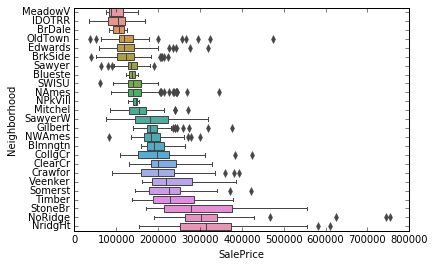

In [15]:
sns.boxplot(x="SalePrice", y="Neighborhood", data=train_source,
            order = train_source.groupby('Neighborhood').SalePrice.median().sort_values().index)

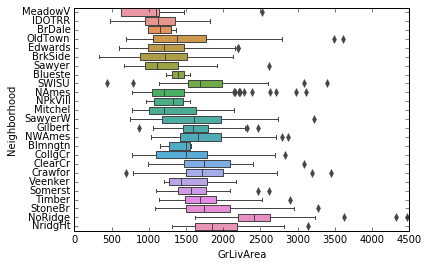

In [16]:
sns.boxplot(x="GrLivArea", y="Neighborhood", data=train_source,
            #ax=axarr[1][0],
                        order = train_source.groupby('Neighborhood').SalePrice.median().sort_values().index)

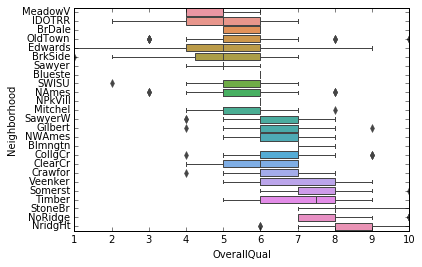

In [17]:
sns.boxplot(x="OverallQual", y="Neighborhood", data=train_source,
            #ax=axarr[1][1],
                        order = train_source.groupby('Neighborhood').SalePrice.median().sort_values().index)

In [18]:
print(train_source.shape)
print(test_source.shape)

(1458, 81)
(1459, 81)


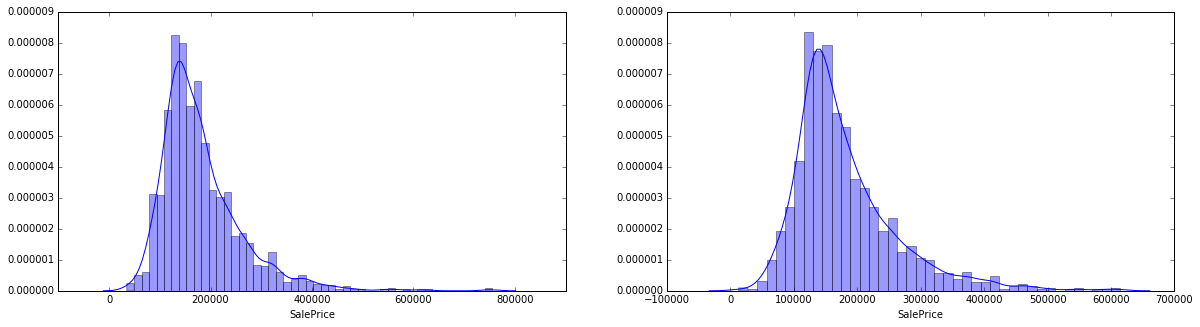

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[20,5])

sns.distplot(train_source['SalePrice'],ax=axes[0]);
sns.distplot(test_source['SalePrice'],ax=axes[1]);

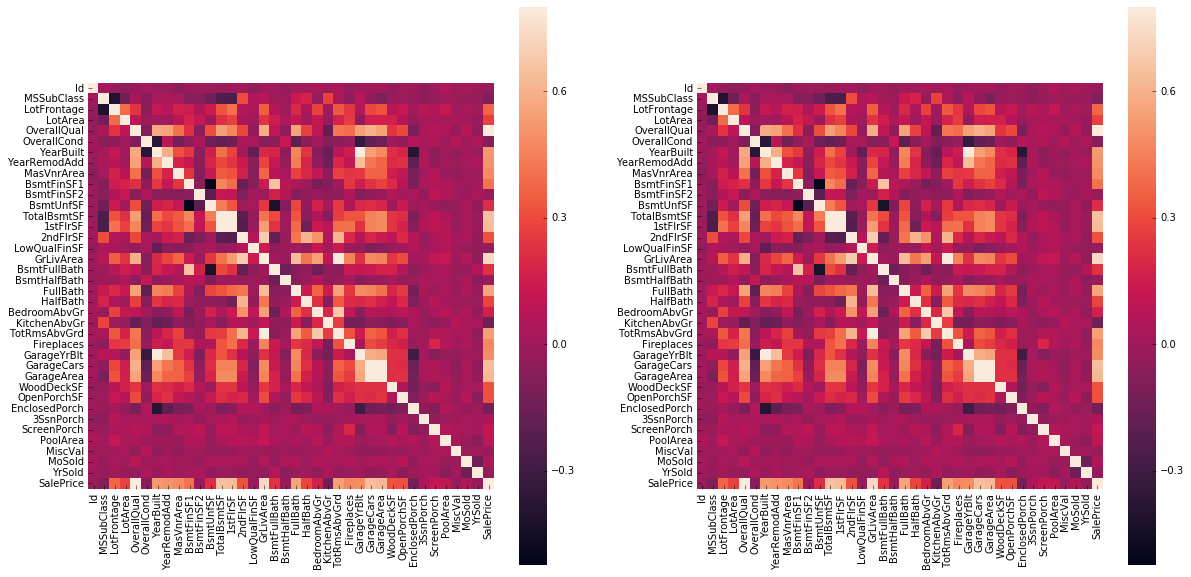

In [20]:
#correlation matrix
corrmat_train = train_source.corr()
corrmat_test = train_source.corr()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[20,10])
sns.heatmap(corrmat_train, vmax=.8, square=True,ax=axes[0]);
sns.heatmap(corrmat_test, vmax=.8, square=True,ax=axes[1]);

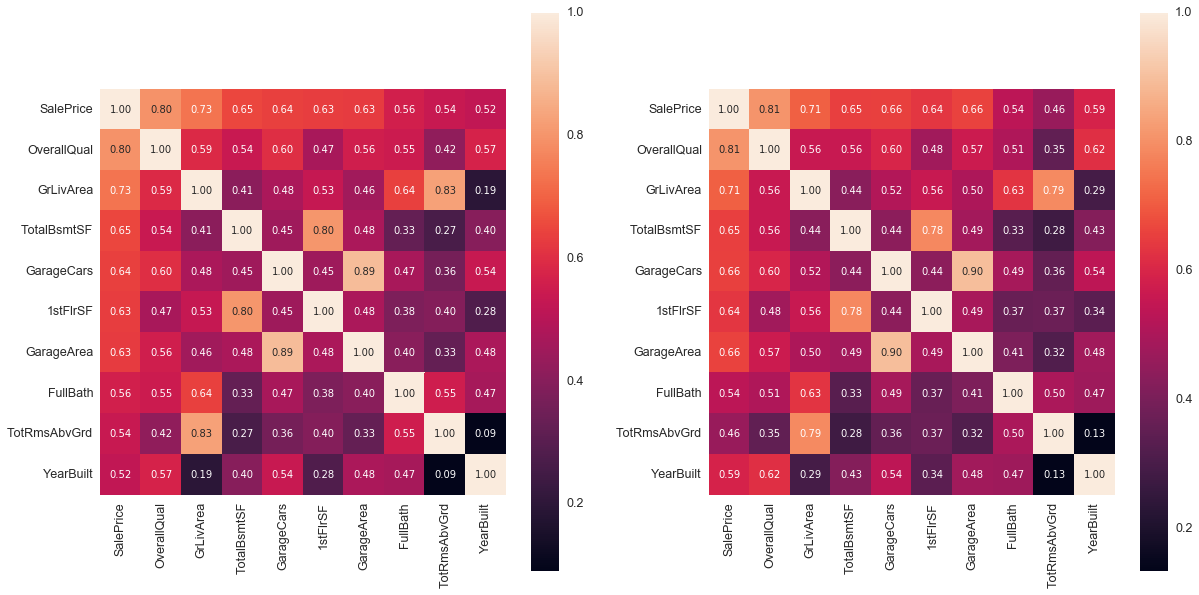

In [21]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols_train = corrmat_train.nlargest(k, 'SalePrice')['SalePrice'].index
cols_test = corrmat_test.nlargest(k, 'SalePrice')['SalePrice'].index

#cm = np.corrcoef(train_source[cols].values.T)
cm_train = train_source[cols_train].corr()
cm_test = test_source[cols_test].corr()

sns.set(font_scale=1.25)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[20,10])

sns.heatmap(cm_train, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols_train.values, xticklabels=cols_train.values,ax=axes[0])
sns.heatmap(cm_test, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols_test.values, xticklabels=cols_test.values,ax=axes[1])

In [22]:
#scatterplot
#sns.set()
#cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt','LotArea']
#sns.pairplot(train_source[cols], size = 2.5)
#plt.show();

In [23]:
train_source["_source"] = "train"
test_source["_source"] = "test"

all_source = pd.concat([train_source,test_source])

print(all_source.shape)
print(all_source.columns)

all_source.set_index('Id', inplace = True)

(2917, 82)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 

***Droping varaibles***

In [24]:
all_source.drop(['Street','Utilities','Condition2','Exterior2nd','MasVnrArea','PoolQC','MiscFeature','MiscVal'],
               inplace=True, axis = 1
               )

In [25]:
#missing data
total = all_source.isnull().sum().sort_values(ascending=False)
percent = (all_source.isnull().sum() / all_source.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data["Total"] > 0]

,Total,Percent
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageYrBlt,159,0.054508
GarageQual,159,0.054508
GarageCond,159,0.054508
GarageFinish,159,0.054508
GarageType,157,0.053822
BsmtCond,82,0.028111


**Missing values**

In [26]:
all_source.loc[[2127],['GarageCond']] = all_source.GarageCond.mode()
all_source.loc[[2127],['GarageQual']] = all_source.GarageQual.mode()
all_source.loc[[2127],['GarageFinish']] = all_source.GarageFinish.mode()

all_source.loc[[2577],['GarageCars']] = 0
all_source.loc[[2577],['GarageArea']] = 0
all_source.loc[[2577],['GarageType']] = np.nan

all_source.loc[[333],['BsmtFinType2']] = all_source.BsmtFinType2.mode()
all_source.loc[[949, 1488, 2349],['BsmtExposure']] = all_source.BsmtExposure.mode()
all_source.loc[[2041, 2186, 2525],['BsmtCond']] = all_source.BsmtCond.mode()
all_source.loc[[2219],['BsmtQual']] = all_source.BsmtQual.mode()
all_source.loc[[2593],['GarageYrBlt']] = 2007
all_source.loc[[1916, 2217, 2251, 2905],['MSZoning']] = 'RL'

In [27]:
all_source.loc[all_source['GarageYrBlt'].isnull(),['GarageYrBlt']] = all_source[all_source['GarageYrBlt'].isnull()].YearBuilt

all_source['Fireplaces'].fillna(0, inplace = True)
all_source['Fence'].fillna('None', inplace = True)
all_source['Alley'].fillna('None', inplace = True)

all_source['GarageType'].fillna('None', inplace = True)
all_source['GarageQual'].fillna('None', inplace = True)
all_source['GarageCond'].fillna('None', inplace = True)
all_source['GarageFinish'].fillna('None', inplace = True)

all_source['GarageCars'].fillna(0, inplace = True)
all_source['GarageArea'].fillna(0, inplace = True)

all_source['BsmtQual'].fillna('None', inplace = True)
all_source['BsmtCond'].fillna('None', inplace = True)
all_source['BsmtExposure'].fillna('None', inplace = True)
all_source['BsmtFinType1'].fillna('None', inplace = True)
all_source['BsmtFinType2'].fillna('None', inplace = True)
all_source['MasVnrType'].fillna('None', inplace = True)

all_source['BsmtFullBath'].fillna(0, inplace = True)
all_source['BsmtHalfBath'].fillna(0, inplace = True)
all_source['BsmtFinSF1'].fillna(0, inplace = True)
all_source['BsmtFinSF2'].fillna(0, inplace = True)
all_source['BsmtUnfSF'].fillna(0, inplace = True)
all_source['TotalBsmtSF'].fillna(0, inplace = True)

all_source['Electrical'].fillna('SBrkr', inplace = True) 
all_source['FireplaceQu'].fillna('None', inplace = True)

all_source['Functional'].fillna('Typ', inplace = True)
all_source['SaleType'].fillna('WD', inplace = True)

all_source['Exterior1st'].fillna('VinylSd', inplace = True)
all_source['KitchenQual'].fillna('TA', inplace = True)

In [28]:
LotFrontage_median_dict = all_source[all_source["_source"] == "train"].groupby(['Neighborhood']).LotFrontage.median()
all_source.loc[all_source['LotFrontage'].isnull(),['LotFrontage']] = all_source[all_source['LotFrontage'].isnull()].Neighborhood
all_source['LotFrontage'].replace(LotFrontage_median_dict , inplace = True)

***New Features***

In [29]:
all_source["TotBathrooms"] = all_source['BsmtFullBath'] + all_source['FullBath'] + all_source['BsmtHalfBath'] * 0.5 +  all_source['HalfBath'] * 0.5
all_source["TotalPorchSF"] = all_source['OpenPorchSF'] + all_source['EnclosedPorch'] + all_source['3SsnPorch'] + all_source['ScreenPorch']

all_source["Remod"] = (all_source["YearBuilt"] == all_source["YearRemodAdd"]).astype(int)
all_source["IsNew"] = (all_source["YrSold"] <= all_source["YearBuilt"]).astype(int)
all_source["Age"] = all_source["YrSold"] - all_source["YearRemodAdd"]

all_source["Pool_Flag"] = (all_source.PoolArea > 0).astype(int) 
all_source["Heating_Gas"] = (all_source.Heating == "GasA").astype(int)  
all_source["LandSlope_Flag"] = (all_source.LandSlope == "Gtl").astype(int) 
all_source["BsmtFinSF2_Flag"] = (all_source.BsmtFinSF2 > 0).astype(int) 
all_source["LowQualFinSF_Flag"] = (all_source.LowQualFinSF > 0).astype(int) 
all_source["WoodDeckSF_Flag"] = (all_source.WoodDeckSF > 0).astype(int) 
all_source["TotalPorchSF_Flag"] = (all_source.TotalPorchSF > 0).astype(int) 

***Droping variables***

In [30]:
all_source.drop([
        'LandSlope','BsmtFinSF2','LowQualFinSF','PoolArea','Heating',
        'BsmtHalfBath','BsmtFullBath','HalfBath','FullBath','OpenPorchSF','EnclosedPorch', '3SsnPorch','ScreenPorch'],
               inplace=True, axis = 1
               )

In [31]:
#missing data
total = all_source.isnull().sum().sort_values(ascending=False)
percent = (all_source.isnull().sum() / all_source.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data["Total"] > 0]

,Total,Percent


**Feature Engineering**

In [32]:
cols = ['OverallQual','Fireplaces','GarageCars']

all_source = AddPolynomialFeatures(all_source,cols,2)

***QBins and Bins***

In [33]:
#LotArea - 8
all_source['LotArea_Bin'] = pct_rank_qcut(all_source['LotArea'], 8)

all_source['YearBuilt_Bin'] = pd.cut(all_source['YearBuilt'], bins=7,labels = range(1,7+1,1))
all_source['BsmtFinSF1_Bin'] = pd.cut(all_source['BsmtFinSF1'], bins=4,labels = range(1,4+1,1))
all_source['BsmtUnfSF_Bin'] = pd.cut(all_source['BsmtUnfSF'], bins=3,labels = range(1,3+1,1))
all_source['TotalBsmtSF_Bin'] = pd.cut(all_source['TotalBsmtSF'], bins=8,labels = range(1,8+1,1))
all_source['1stFlrSF_Bin'] = pd.cut(all_source['1stFlrSF'], bins=6,labels = range(1,6+1,1))
all_source['2ndFlrSF_Bin'] = pd.cut(all_source['2ndFlrSF'], bins=6,labels = range(1,6+1,1))
all_source['GrLivArea_Bin'] = pd.cut(all_source['GrLivArea'], bins=6,labels = range(1,6+1,1))
all_source['GarageYrBlt_Bin'] = pd.cut(all_source['GarageYrBlt'], bins=3,labels = range(1,3+1,1))
all_source['GarageArea_Bin'] = pd.cut(all_source['GarageArea'], bins=3,labels = range(1,3+1,1))
all_source['WoodDeckSF_Bin'] = pd.cut(all_source['YearBuilt'], bins=3,labels = range(1,3+1,1))
all_source['TotalPorchSF_Bin'] = pd.cut(all_source['TotalPorchSF'], bins=4,labels = range(1,4+1,1))


**Dummy Variables**

In [34]:
dummy_features = ['LotArea_Bin',
                'YearBuilt_Bin','BsmtFinSF1_Bin','BsmtUnfSF_Bin','TotalBsmtSF_Bin','1stFlrSF_Bin','2ndFlrSF_Bin',
                'GrLivArea_Bin','GarageYrBlt_Bin','GarageArea_Bin','TotalPorchSF_Bin','WoodDeckSF_Bin',
                'MSSubClass','MSZoning','Alley',
                'LotShape','LandContour','LotConfig','Neighborhood','Condition1','BldgType','HouseStyle',
                'RoofStyle','RoofMatl','Exterior1st','MasVnrType','ExterCond','Foundation','BsmtExposure',
                'BsmtFinType1','BsmtFinType2','Electrical','GarageType','GarageQual','GarageCond','PavedDrive',
                'Fence','MoSold','YrSold','GarageFinish','SaleType','SaleCondition'
                 ]

In [35]:
numeric_features = ['LotFrontage','OverallQual','OverallCond','YearRemodAdd',
                'BedroomAbvGr','TotRmsAbvGrd','Fireplaces','GarageCars','KitchenAbvGr',
                'OverallQual^2','Fireplaces^2','GarageCars^2',
                'TotBathrooms','Age',
                'LotArea',
                'YearBuilt','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
                'GrLivArea','GarageYrBlt','GarageArea','TotalPorchSF','WoodDeckSF',
                   ]

flag_features = ['IsNew','Heating_Gas','Pool_Flag','LandSlope_Flag',
                 'BsmtFinSF2_Flag','LowQualFinSF_Flag','WoodDeckSF_Flag','TotalPorchSF_Flag','Remod']

In [36]:
nominal_features = ['ExterQual','BsmtQual','BsmtCond','HeatingQC','CentralAir',
                    'KitchenQual','Functional','FireplaceQu'
                   ]

other_features = ['Id','SalePrice','_source']

print(len(all_source.columns),len(dummy_features),len(numeric_features),len(nominal_features),len(flag_features),len(other_features))

87 42 26 8 9 3


In [37]:
central_air_dict = {'Y': 1, 'N': 0, 'None': 0}
functional_dict = {'Typ': 7.0, 'Min1': 6.0, 'Min2': 5.0,'Mod': 4.0,'Maj1': 3.0,'Maj2': 2.0, 'Sev': 1.0, 'Sal': 0, 'None': 0}
quality_dict = {"Ex": [5], "Gd":[4], "TA": [3], "Fa": [2], "Po": [1], "None" : [0], nan:[0]}

all_source['ExterQual'].replace(quality_dict , inplace = True)
all_source['BsmtQual'].replace(quality_dict , inplace = True)
all_source['BsmtCond'].replace(quality_dict , inplace = True)
all_source['HeatingQC'].replace(quality_dict , inplace = True)
all_source['KitchenQual'].replace(quality_dict , inplace = True)
all_source['FireplaceQu'].replace(quality_dict , inplace = True)

all_source['Functional'].replace(functional_dict , inplace = True)
all_source['CentralAir'].replace(central_air_dict , inplace = True)

In [38]:

neighborhood_dict = {
    "MeadowV": [0],"IDOTRR": [0],"BrDale": [0],
    "BrkSide": [1],"Edwards": [1],"OldTown": [1],
    "Sawyer": [2],"Blueste": [2],"SWISU": [2],"NPkVill": [2],"NAmes": [2],"Mitchel": [2],
    "SawyerW": [3],"NWAmes": [3],"Gilbert": [3],"Blmngtn": [3],"CollgCr": [3],"Crawfor": [3],"ClearCr": [3],
    "Somerst": [4],"Veenker": [4],"Timber": [4],
    "StoneBr": [5],"NridgHt": [5],"NoRidge": [5] 
}

all_source["Neighborhood_Num"] = all_source["Neighborhood"]

all_source['Neighborhood_Num'].replace(neighborhood_dict , inplace = True)

'''
neighborhood_dict1 = {
    "MeadowV": [0],"IDOTRR": [1],"BrDale": [2],
    "BrkSide": [3],"Edwards": [4],"OldTown": [5],"Sawyer": [6],
    "Blueste": [7],"SWISU": [8],"NPkVill": [9],"NAmes": [10],
    "Mitchel": [11],"SawyerW": [12],"NWAmes": [13],"Gilbert": [14],
    "Blmngtn": [15],"CollgCr": [16],"Crawfor": [17],"ClearCr": [18],
    "Somerst": [19],"Veenker": [20],"Timber": [21],
    "StoneBr": [22],"NridgHt": [23],"NoRidge": [24] 
}

all_source["Neighborhood_Num1"] = all_source["Neighborhood"]

all_source['Neighborhood_Num1'].replace(neighborhood_dict1 , inplace = True)
'''

mssubclass_dict = {
    nan: [0],150 : [0],
    30 : [1],180 : [1],45 : [1],
    190 : [2],90 : [2],50 : [2],
    80 : [2], 160 : [3],40 : [3],
    70 : [4], 80 : [4], 20 : [4],75 : [4],
    120 : [5],
    60 : [6]
}
all_source['MSSubClass_Num'] = all_source['MSSubClass']
all_source['MSSubClass_Num'].replace(mssubclass_dict , inplace = True)
'''
exterior_dict = {
    nan: [0],
    "BrkComm":[1],"AsphShn":[1],"CBlock":[1],"Brk Cmn":[1],"AsbShng":[1],
    "MetalSd":[2],"Wd Sdng":[2],"WdShing":[2],"Wd Shng":[2],"Stucco":[2],"HdBoard":[2],"Plywood":[2],"BrkFace":[2],
    "VinylSd":[3],"CemntBd":[3],"CmentBd":[3],"Stone":[3],"ImStucc":[3],"Other" : [3],'PreCast' : [3]
}

all_source['Exterior1st_Num'] = all_source['Exterior1st']

all_source['Exterior1st_Num'].replace(exterior_dict , inplace = True)
'''

'\nexterior_dict = {\n    nan: [0],\n    "BrkComm":[1],"AsphShn":[1],"CBlock":[1],"Brk Cmn":[1],"AsbShng":[1],\n    "MetalSd":[2],"Wd Sdng":[2],"WdShing":[2],"Wd Shng":[2],"Stucco":[2],"HdBoard":[2],"Plywood":[2],"BrkFace":[2],\n    "VinylSd":[3],"CemntBd":[3],"CmentBd":[3],"Stone":[3],"ImStucc":[3],"Other" : [3],\'PreCast\' : [3]\n}\n\nall_source[\'Exterior1st_Num\'] = all_source[\'Exterior1st\']\n\nall_source[\'Exterior1st_Num\'].replace(exterior_dict , inplace = True)\n'

In [39]:
'''
all_source['BsmtQual'].fillna('None', inplace = True)
all_source['BsmtQual'].replace(quality_dict , inplace = True)

bsmt_exposure_dict = {"Gd": [4], "Av":[3], "Mn": [2], "No": [1],  "None":[0], nan:[0]}
all_source['BsmtExposure'].fillna('None', inplace = True)
all_source['BsmtExposure'].replace(bsmt_exposure_dict , inplace = True)

basement_finish_dict = {"GLQ": [6], "ALQ":[5], "BLQ": [4], "Rec": [3], "LwQ": [2], "Unf" : [1], "None":[0], nan:[0]}
all_source['BsmtFinType1'].fillna('None', inplace = True)
all_source['BsmtFinType1'].replace(basement_finish_dict , inplace = True)

all_source['BsmtFinType2'].fillna('None', inplace = True)
all_source['BsmtFinType2'].replace(basement_finish_dict , inplace = True)

mszoning_dict = {"FV": [5], "RL": [4], "RH" : [3], "RM" : [2],"C (all)" : [1],"None":[0], nan:[0]}
all_source['MSZoning'].replace(mszoning_dict , inplace = True)

paved_drive_dict = {"N": [0], "P":[1],"Y":[2], nan:[0]}
all_source['PavedDrive'].replace(paved_drive_dict , inplace = True)

all_source['Exterior2nd'].replace(exterior_dict , inplace = True)
'''

'\nall_source[\'BsmtQual\'].fillna(\'None\', inplace = True)\nall_source[\'BsmtQual\'].replace(quality_dict , inplace = True)\n\nbsmt_exposure_dict = {"Gd": [4], "Av":[3], "Mn": [2], "No": [1],  "None":[0], nan:[0]}\nall_source[\'BsmtExposure\'].fillna(\'None\', inplace = True)\nall_source[\'BsmtExposure\'].replace(bsmt_exposure_dict , inplace = True)\n\nbasement_finish_dict = {"GLQ": [6], "ALQ":[5], "BLQ": [4], "Rec": [3], "LwQ": [2], "Unf" : [1], "None":[0], nan:[0]}\nall_source[\'BsmtFinType1\'].fillna(\'None\', inplace = True)\nall_source[\'BsmtFinType1\'].replace(basement_finish_dict , inplace = True)\n\nall_source[\'BsmtFinType2\'].fillna(\'None\', inplace = True)\nall_source[\'BsmtFinType2\'].replace(basement_finish_dict , inplace = True)\n\nmszoning_dict = {"FV": [5], "RL": [4], "RH" : [3], "RM" : [2],"C (all)" : [1],"None":[0], nan:[0]}\nall_source[\'MSZoning\'].replace(mszoning_dict , inplace = True)\n\npaved_drive_dict = {"N": [0], "P":[1],"Y":[2], nan:[0]}\nall_source[\'Pav

In [40]:
all_ohe = pd.get_dummies(all_source, columns = dummy_features)

In [41]:
all_ohe.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,BsmtCond,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,SalePrice,TotBathrooms,TotalPorchSF,Remod,IsNew,Age,Pool_Flag,Heating_Gas,LandSlope_Flag,BsmtFinSF2_Flag,LowQualFinSF_Flag,WoodDeckSF_Flag,TotalPorchSF_Flag,OverallQual^2,Fireplaces^2,GarageCars^2,Neighborhood_Num,MSSubClass_Num,LotArea_Bin_1,LotArea_Bin_2,LotArea_Bin_3,LotArea_Bin_4,LotArea_Bin_5,LotArea_Bin_6,LotArea_Bin_7,LotArea_Bin_8,YearBuilt_Bin_1,YearBuilt_Bin_2,YearBuilt_Bin_3,YearBuilt_Bin_4,YearBuilt_Bin_5,YearBuilt_Bin_6,YearBuilt_Bin_7,BsmtFinSF1_Bin_1,BsmtFinSF1_Bin_2,BsmtFinSF1_Bin_3,BsmtFinSF1_Bin_4,BsmtUnfSF_Bin_1,BsmtUnfSF_Bin_2,BsmtUnfSF_Bin_3,TotalBsmtSF_Bin_1,TotalBsmtSF_Bin_2,TotalBsmtSF_Bin_3,TotalBsmtSF_Bin_4,TotalBsmtSF_Bin_5,TotalBsmtSF_Bin_6,TotalBsmtSF_Bin_7,TotalBsmtSF_Bin_8,1stFlrSF_Bin_1,1stFlrSF_Bin_2,1stFlrSF_Bin_3,1stFlrSF_Bin_4,1stFlrSF_Bin_5,1stFlrSF_Bin_6,2ndFlrSF_Bin_1,2ndFlrSF_Bin_2,2ndFlrSF_Bin_3,2ndFlrSF_Bin_4,2ndFlrSF_Bin_5,2ndFlrSF_Bin_6,GrLivArea_Bin_1,GrLivArea_Bin_2,GrLivArea_Bin_3,GrLivArea_Bin_4,GrLivArea_Bin_5,GrLivArea_Bin_6,GarageYrBlt_Bin_1,GarageYrBlt_Bin_2,GarageYrBlt_Bin_3,GarageArea_Bin_1,GarageArea_Bin_2,GarageArea_Bin_3,TotalPorchSF_Bin_1,TotalPorchSF_Bin_2,TotalPorchSF_Bin_3,TotalPorchSF_Bin_4,WoodDeckSF_Bin_1,WoodDeckSF_Bin_2,WoodDeckSF_Bin_3,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,...,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fe

In [42]:
all_ohe.head(3)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,BsmtCond,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,SalePrice,_source,TotBathrooms,TotalPorchSF,Remod,IsNew,Age,Pool_Flag,Heating_Gas,LandSlope_Flag,BsmtFinSF2_Flag,LowQualFinSF_Flag,WoodDeckSF_Flag,TotalPorchSF_Flag,OverallQual^2,Fireplaces^2,GarageCars^2,Neighborhood_Num,MSSubClass_Num,LotArea_Bin_1,LotArea_Bin_2,LotArea_Bin_3,LotArea_Bin_4,LotArea_Bin_5,LotArea_Bin_6,LotArea_Bin_7,LotArea_Bin_8,YearBuilt_Bin_1,YearBuilt_Bin_2,YearBuilt_Bin_3,YearBuilt_Bin_4,YearBuilt_Bin_5,YearBuilt_Bin_6,YearBuilt_Bin_7,BsmtFinSF1_Bin_1,BsmtFinSF1_Bin_2,BsmtFinSF1_Bin_3,BsmtFinSF1_Bin_4,BsmtUnfSF_Bin_1,BsmtUnfSF_Bin_2,BsmtUnfSF_Bin_3,TotalBsmtSF_Bin_1,TotalBsmtSF_Bin_2,TotalBsmtSF_Bin_3,TotalBsmtSF_Bin_4,TotalBsmtSF_Bin_5,TotalBsmtSF_Bin_6,TotalBsmtSF_Bin_7,TotalBsmtSF_Bin_8,1stFlrSF_Bin_1,1stFlrSF_Bin_2,1stFlrSF_Bin_3,1stFlrSF_Bin_4,1stFlrSF_Bin_5,1stFlrSF_Bin_6,2ndFlrSF_Bin_1,2ndFlrSF_Bin_2,2ndFlrSF_Bin_3,2ndFlrSF_Bin_4,2ndFlrSF_Bin_5,2ndFlrSF_Bin_6,GrLivArea_Bin_1,GrLivArea_Bin_2,GrLivArea_Bin_3,GrLivArea_Bin_4,GrLivArea_Bin_5,GrLivArea_Bin_6,GarageYrBlt_Bin_1,GarageYrBlt_Bin_2,GarageYrBlt_Bin_3,GarageArea_Bin_1,GarageArea_Bin_2,GarageArea_Bin_3,TotalPorchSF_Bin_1,TotalPorchSF_Bin_2,TotalPorchSF_Bin_3,TotalPorchSF_Bin_4,WoodDeckSF_Bin_1,WoodDeckSF_Bin_2,WoodDeckSF_Bin_3,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,...,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fen

In [43]:
from scipy.stats import boxcox
#boxcox_transformed_data = boxcox(original_data)

from sklearn import preprocessing
#centered_scaled_data = preprocessing.scale(original_data)
#all_ohe.set_index('Id')
if 1==1:
    #for col in all_ohe.drop(['SalePrice','_source'],axis = 1).columns:
    for col in numeric_features:

        print(col)

        skew = np.abs(all_ohe[col].skew())
        if skew > 0.8:
            #all_ohe[col] = boxcox(all_ohe[col])
            all_ohe[col] = np.log1p(all_ohe[col])
            #print ("skew", skew)

        std = np.std(all_ohe.loc[all_ohe["_source"] == "train",col])
        mean = all_ohe.loc[all_ohe["_source"] == "train",col].mean()

        #std = np.std(all_ohe.loc[:,col])
        #mean = all_ohe.loc[:,col].mean()
        all_ohe[col] = (all_ohe[col] - mean) / std    

LotFrontage
OverallQual
OverallCond
YearRemodAdd
BedroomAbvGr
TotRmsAbvGrd
Fireplaces
GarageCars
KitchenAbvGr
OverallQual^2
Fireplaces^2
GarageCars^2
TotBathrooms
Age
LotArea
YearBuilt
BsmtFinSF1
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
GrLivArea
GarageYrBlt
GarageArea
TotalPorchSF
WoodDeckSF


In [44]:
all_source.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice,_source,TotBathrooms,TotalPorchSF,Remod,IsNew,Age,Pool_Flag,Heating_Gas,LandSlope_Flag,BsmtFinSF2_Flag,LowQualFinSF_Flag,WoodDeckSF_Flag,TotalPorchSF_Flag,OverallQual^2,Fireplaces^2,GarageCars^2,LotArea_Bin,YearBuilt_Bin,BsmtFinSF1_Bin,BsmtUnfSF_Bin,TotalBsmtSF_Bin,1stFlrSF_Bin,2ndFlrSF_Bin,GrLivArea_Bin,GarageYrBlt_Bin,GarageArea_Bin,WoodDeckSF_Bin,TotalPorchSF_Bin,Neighborhood_Num,MSSubClass_Num
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65,8450,None,Reg,Lvl,Inside,CollgCr,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,BrkFace,4,TA,PConc,4,3,No,GLQ,706,Unf,150,856,5,1,SBrkr,856,854,1710,3,1,4,8,7,0,0,Attchd,2003,RFn,2,548,TA,TA,Y,0,None,2,2008,WD,Normal,208500,train,3.5,61,1,0,5,0,1,1,0,0,0,1,49,0,4,3,7,1,1,2,1,3,2,3,2,3,1,3,6
2,20,RL,80,9600,None,Reg,Lvl,FR2,Veenker,Feedr,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,None,3,TA,CBlock,4,3,Gd,ALQ,978,Unf,284,1262,5,1,SBrkr,1262,0,1262,3,1,3,6,7,1,3,Attchd,1976,RFn,2,460,TA,TA,Y,298,None,5,2007,WD,Normal,181500,train,2.5,0,1,0,31,0,1,1,0,0,1,0,36,1,4,5,6,1,1,2,2,1,2,3,1,3,1,4,4
3,60,RL,68,11250,None,IR1,Lvl,Inside,CollgCr,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,BrkFace,4,TA,PConc,4,3,Mn,GLQ,486,Unf,434,920,5,1,SBrkr,920,866,1786,3,1,4,6,7,1,3,Attchd,2001,RFn,2,608,TA,TA,Y,0,None,9,2008,WD,Normal,223500,train,3.5,42,0,0,6,0,1,1,0,0,0,1,49,1,4,6,7,1,1,2,1,3,2,3,2,3,1,3,6
4,70,RL,60,9550,None,IR1,Lvl,Corner,Crawfor,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,None,3,TA,BrkTil,3,4,No,ALQ,216,Unf,540,756,4,1,SBrkr,961,756,1717,3,1,4,7,7,1,4,Detchd,1998,Unf,3,642,TA,TA,Y,0,None,2,2006,WD,Abnorml,140000,train,2.0,307,0,0,36,0,1,1,0,0,0,1,49,1,9,5,3,1,1,2,1,3,2,3,2,1,2,3,4
5,60,RL,84,14260,None,IR1,Lvl,FR2,NoRidge,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,BrkFace,4,TA,PConc,4,3,Av,GLQ,655,Unf,490,1145,5,1,SBrkr,1145,1053,2198,4,1,4,9,7,1,3,Attchd,2000,RFn,3,836,TA,TA,Y,192,None,12,2008,WD,Normal,250000,train,3.5,84,1,0,8,0,1,1,0,0,1,1,64,1,9,8,7,1,1,2,2,4,3,3,2,3,1,5,6


In [45]:
all_ohe.head(5)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,BsmtCond,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,SalePrice,_source,TotBathrooms,TotalPorchSF,Remod,IsNew,Age,Pool_Flag,Heating_Gas,LandSlope_Flag,BsmtFinSF2_Flag,LowQualFinSF_Flag,WoodDeckSF_Flag,TotalPorchSF_Flag,OverallQual^2,Fireplaces^2,GarageCars^2,Neighborhood_Num,MSSubClass_Num,LotArea_Bin_1,LotArea_Bin_2,LotArea_Bin_3,LotArea_Bin_4,LotArea_Bin_5,LotArea_Bin_6,LotArea_Bin_7,LotArea_Bin_8,YearBuilt_Bin_1,YearBuilt_Bin_2,YearBuilt_Bin_3,YearBuilt_Bin_4,YearBuilt_Bin_5,YearBuilt_Bin_6,YearBuilt_Bin_7,BsmtFinSF1_Bin_1,BsmtFinSF1_Bin_2,BsmtFinSF1_Bin_3,BsmtFinSF1_Bin_4,BsmtUnfSF_Bin_1,BsmtUnfSF_Bin_2,BsmtUnfSF_Bin_3,TotalBsmtSF_Bin_1,TotalBsmtSF_Bin_2,TotalBsmtSF_Bin_3,TotalBsmtSF_Bin_4,TotalBsmtSF_Bin_5,TotalBsmtSF_Bin_6,TotalBsmtSF_Bin_7,TotalBsmtSF_Bin_8,1stFlrSF_Bin_1,1stFlrSF_Bin_2,1stFlrSF_Bin_3,1stFlrSF_Bin_4,1stFlrSF_Bin_5,1stFlrSF_Bin_6,2ndFlrSF_Bin_1,2ndFlrSF_Bin_2,2ndFlrSF_Bin_3,2ndFlrSF_Bin_4,2ndFlrSF_Bin_5,2ndFlrSF_Bin_6,GrLivArea_Bin_1,GrLivArea_Bin_2,GrLivArea_Bin_3,GrLivArea_Bin_4,GrLivArea_Bin_5,GrLivArea_Bin_6,GarageYrBlt_Bin_1,GarageYrBlt_Bin_2,GarageYrBlt_Bin_3,GarageArea_Bin_1,GarageArea_Bin_2,GarageArea_Bin_3,TotalPorchSF_Bin_1,TotalPorchSF_Bin_2,TotalPorchSF_Bin_3,TotalPorchSF_Bin_4,WoodDeckSF_Bin_1,WoodDeckSF_Bin_2,WoodDeckSF_Bin_3,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,...,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fen

In [46]:
all_ohe.describe()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,BsmtCond,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,SalePrice,TotBathrooms,TotalPorchSF,Remod,IsNew,Age,Pool_Flag,Heating_Gas,LandSlope_Flag,BsmtFinSF2_Flag,LowQualFinSF_Flag,WoodDeckSF_Flag,TotalPorchSF_Flag,OverallQual^2,Fireplaces^2,GarageCars^2,Neighborhood_Num,MSSubClass_Num,LotArea_Bin_1,LotArea_Bin_2,LotArea_Bin_3,LotArea_Bin_4,LotArea_Bin_5,LotArea_Bin_6,LotArea_Bin_7,LotArea_Bin_8,YearBuilt_Bin_1,YearBuilt_Bin_2,YearBuilt_Bin_3,YearBuilt_Bin_4,YearBuilt_Bin_5,YearBuilt_Bin_6,YearBuilt_Bin_7,BsmtFinSF1_Bin_1,BsmtFinSF1_Bin_2,BsmtFinSF1_Bin_3,BsmtFinSF1_Bin_4,BsmtUnfSF_Bin_1,BsmtUnfSF_Bin_2,BsmtUnfSF_Bin_3,TotalBsmtSF_Bin_1,TotalBsmtSF_Bin_2,TotalBsmtSF_Bin_3,TotalBsmtSF_Bin_4,TotalBsmtSF_Bin_5,TotalBsmtSF_Bin_6,TotalBsmtSF_Bin_7,TotalBsmtSF_Bin_8,1stFlrSF_Bin_1,1stFlrSF_Bin_2,1stFlrSF_Bin_3,1stFlrSF_Bin_4,1stFlrSF_Bin_5,1stFlrSF_Bin_6,2ndFlrSF_Bin_1,2ndFlrSF_Bin_2,2ndFlrSF_Bin_3,2ndFlrSF_Bin_4,2ndFlrSF_Bin_5,2ndFlrSF_Bin_6,GrLivArea_Bin_1,GrLivArea_Bin_2,GrLivArea_Bin_3,GrLivArea_Bin_4,GrLivArea_Bin_5,GrLivArea_Bin_6,GarageYrBlt_Bin_1,GarageYrBlt_Bin_2,GarageYrBlt_Bin_3,GarageArea_Bin_1,GarageArea_Bin_2,GarageArea_Bin_3,TotalPorchSF_Bin_1,TotalPorchSF_Bin_2,TotalPorchSF_Bin_3,TotalPorchSF_Bin_4,WoodDeckSF_Bin_1,WoodDeckSF_Bin_2,WoodDeckSF_Bin_3,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,...,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fe

In [47]:
print(all_ohe.shape)
print(all_source.shape)

(2917, 322)
(2917, 89)


In [48]:
print(all_ohe.SalePrice.skew())
all_ohe.SalePrice = np.log1p(all_ohe.SalePrice)
print(all_ohe.SalePrice.skew())

1.74485053505
-0.011632580326


In [49]:
all_ohe = all_ohe.reset_index()

train = all_ohe[all_ohe["_source"] == "train"].copy(deep = True)
test = all_ohe[all_ohe["_source"] == "test"].copy(deep = True)

train.drop(['_source'],axis = 1,inplace = True)
test.drop(['_source'],axis = 1,inplace = True)

train.to_csv('./output/train.csv')

In [50]:
'''
from sklearn.utils import shuffle

from sklearn.model_selection import ShuffleSplit

split = ShuffleSplit(n_splits=1,test_size = 0.1, random_state=42)

for train_index, test_index in split.split(train):
    train_set = train.loc[train_index]
    test_set = train.loc[test_index]

train = train_set.copy(deep = True)
test = test_set.copy(deep = True)
'''

'\nfrom sklearn.utils import shuffle\n\nfrom sklearn.model_selection import ShuffleSplit\n\nsplit = ShuffleSplit(n_splits=1,test_size = 0.1, random_state=42)\n\nfor train_index, test_index in split.split(train):\n    train_set = train.loc[train_index]\n    test_set = train.loc[test_index]\n\ntrain = train_set.copy(deep = True)\ntest = test_set.copy(deep = True)\n'

In [51]:
print(train.shape)
print(test.shape)

(1458, 322)
(1459, 322)


In [52]:
model_XGB = XGBRegressor(random_state = 42)

model_XGB.fit(train.drop(['Id','SalePrice'],axis = 1), train.SalePrice)

model_XGB.feature_importances_

feature_importances = pd.DataFrame(model_XGB.feature_importances_,index = train.drop(['Id','SalePrice'],axis = 1).columns, columns=['importance']).sort_values('importance', ascending=False)
cols = feature_importances[feature_importances['importance'] == 0].index
#train.drop(cols,inplace = True, axis = 1)
#test.drop(cols,inplace = True, axis = 1)

In [53]:
feature_importances[feature_importances['importance'] > 0]

,importance
GrLivArea,0.093379
OverallCond,0.057725
LotArea,0.057725
OverallQual,0.054329
TotalPorchSF,0.042445
LotFrontage,0.039049
TotalBsmtSF,0.037351
GarageArea,0.035654
BsmtFinSF1,0.035654
1stFlrSF,0.023769


In [54]:
print(train.shape)
print(test.shape)

(1458, 322)
(1459, 322)


**Models tuning**

In [55]:
train.describe()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,BsmtCond,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,SalePrice,TotBathrooms,TotalPorchSF,Remod,IsNew,Age,Pool_Flag,Heating_Gas,LandSlope_Flag,BsmtFinSF2_Flag,LowQualFinSF_Flag,WoodDeckSF_Flag,TotalPorchSF_Flag,OverallQual^2,Fireplaces^2,GarageCars^2,Neighborhood_Num,MSSubClass_Num,LotArea_Bin_1,LotArea_Bin_2,LotArea_Bin_3,LotArea_Bin_4,LotArea_Bin_5,LotArea_Bin_6,LotArea_Bin_7,LotArea_Bin_8,YearBuilt_Bin_1,YearBuilt_Bin_2,YearBuilt_Bin_3,YearBuilt_Bin_4,YearBuilt_Bin_5,YearBuilt_Bin_6,YearBuilt_Bin_7,BsmtFinSF1_Bin_1,BsmtFinSF1_Bin_2,BsmtFinSF1_Bin_3,BsmtFinSF1_Bin_4,BsmtUnfSF_Bin_1,BsmtUnfSF_Bin_2,BsmtUnfSF_Bin_3,TotalBsmtSF_Bin_1,TotalBsmtSF_Bin_2,TotalBsmtSF_Bin_3,TotalBsmtSF_Bin_4,TotalBsmtSF_Bin_5,TotalBsmtSF_Bin_6,TotalBsmtSF_Bin_7,TotalBsmtSF_Bin_8,1stFlrSF_Bin_1,1stFlrSF_Bin_2,1stFlrSF_Bin_3,1stFlrSF_Bin_4,1stFlrSF_Bin_5,1stFlrSF_Bin_6,2ndFlrSF_Bin_1,2ndFlrSF_Bin_2,2ndFlrSF_Bin_3,2ndFlrSF_Bin_4,2ndFlrSF_Bin_5,2ndFlrSF_Bin_6,GrLivArea_Bin_1,GrLivArea_Bin_2,GrLivArea_Bin_3,GrLivArea_Bin_4,GrLivArea_Bin_5,GrLivArea_Bin_6,GarageYrBlt_Bin_1,GarageYrBlt_Bin_2,GarageYrBlt_Bin_3,GarageArea_Bin_1,GarageArea_Bin_2,GarageArea_Bin_3,TotalPorchSF_Bin_1,TotalPorchSF_Bin_2,TotalPorchSF_Bin_3,TotalPorchSF_Bin_4,WoodDeckSF_Bin_1,WoodDeckSF_Bin_2,WoodDeckSF_Bin_3,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,...,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_Gd

In [56]:
train[train["LotFrontage"].isnull()]

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,BsmtCond,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,SalePrice,TotBathrooms,TotalPorchSF,Remod,IsNew,Age,Pool_Flag,Heating_Gas,LandSlope_Flag,BsmtFinSF2_Flag,LowQualFinSF_Flag,WoodDeckSF_Flag,TotalPorchSF_Flag,OverallQual^2,Fireplaces^2,GarageCars^2,Neighborhood_Num,MSSubClass_Num,LotArea_Bin_1,LotArea_Bin_2,LotArea_Bin_3,LotArea_Bin_4,LotArea_Bin_5,LotArea_Bin_6,LotArea_Bin_7,LotArea_Bin_8,YearBuilt_Bin_1,YearBuilt_Bin_2,YearBuilt_Bin_3,YearBuilt_Bin_4,YearBuilt_Bin_5,YearBuilt_Bin_6,YearBuilt_Bin_7,BsmtFinSF1_Bin_1,BsmtFinSF1_Bin_2,BsmtFinSF1_Bin_3,BsmtFinSF1_Bin_4,BsmtUnfSF_Bin_1,BsmtUnfSF_Bin_2,BsmtUnfSF_Bin_3,TotalBsmtSF_Bin_1,TotalBsmtSF_Bin_2,TotalBsmtSF_Bin_3,TotalBsmtSF_Bin_4,TotalBsmtSF_Bin_5,TotalBsmtSF_Bin_6,TotalBsmtSF_Bin_7,TotalBsmtSF_Bin_8,1stFlrSF_Bin_1,1stFlrSF_Bin_2,1stFlrSF_Bin_3,1stFlrSF_Bin_4,1stFlrSF_Bin_5,1stFlrSF_Bin_6,2ndFlrSF_Bin_1,2ndFlrSF_Bin_2,2ndFlrSF_Bin_3,2ndFlrSF_Bin_4,2ndFlrSF_Bin_5,2ndFlrSF_Bin_6,GrLivArea_Bin_1,GrLivArea_Bin_2,GrLivArea_Bin_3,GrLivArea_Bin_4,GrLivArea_Bin_5,GrLivArea_Bin_6,GarageYrBlt_Bin_1,GarageYrBlt_Bin_2,GarageYrBlt_Bin_3,GarageArea_Bin_1,GarageArea_Bin_2,GarageArea_Bin_3,TotalPorchSF_Bin_1,TotalPorchSF_Bin_2,TotalPorchSF_Bin_3,TotalPorchSF_Bin_4,WoodDeckSF_Bin_1,WoodDeckSF_Bin_2,WoodDeckSF_Bin_3,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,...,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Fence_GdPrv,Fence_Gd

***Models Tuning***

***Elastic Net***

In [57]:
model_ElasticNet = linear_model.ElasticNet(random_state = 42)
e1, e2 = MyKFold(model_ElasticNet,train,k=10,model_name="ElasticNet")

ERROR ElasticNet train avg 0.3995474223217628:
ERROR ElasticNet valid avg 0.39887838209985904:


***Linear Regression***

In [58]:
model_LinearRegression = linear_model.LinearRegression()
e1, e2 = MyKFold(model_LinearRegression,train,k=10,model_name="LinearRegression")

ERROR LinearRegression train avg 0.08765851695292848:
ERROR LinearRegression valid avg 0.12001439364294868:


***Random Forest***

In [59]:
model_RF = RandomForestRegressor(random_state = 42)
e1, e2 = MyKFold(model_RF,train,k=10,model_name="RandomForest")

ERROR RandomForest train avg 0.061349647820665945:
ERROR RandomForest valid avg 0.1435584570566303:


In [60]:
model_RF = RandomForestRegressor(bootstrap = False, max_depth = 25,max_features = 'sqrt',
                                 min_samples_leaf = 1,min_samples_split = 2, n_estimators = 1500, random_state = 42)
e1, e2 = MyKFold(model_RF,train,k=10,model_name="RandomForest")

ERROR RandomForest train avg 0.00011956860926264747:
ERROR RandomForest valid avg 0.12939684933203785:


***Ada Boost***

In [61]:
model_AdaBoost = AdaBoostRegressor(random_state=42)
e1, e2 = MyKFold(model_AdaBoost,train,k=10,model_name="AdaBoost")

ERROR AdaBoost train avg 0.14428368288702748:
ERROR AdaBoost valid avg 0.16551997076902808:


In [62]:
model_AdaBoost = AdaBoostRegressor(n_estimators=1300, learning_rate=3.1, loss='linear', random_state=42)
e1, e2 = MyKFold(model_AdaBoost,train,k=10,model_name="AdaBoost")

ERROR AdaBoost train avg 0.13264108418373605:
ERROR AdaBoost valid avg 0.15550167323672576:


***KNN***

In [63]:
model_KNN = KNeighborsRegressor()
e1, e2 = MyKFold(model_KNN,train,k=10,model_name="KNeighborsRegressor")

ERROR KNeighborsRegressor train avg 0.11930455150700496:
ERROR KNeighborsRegressor valid avg 0.14649229837935357:


In [64]:
model_KNN = KNeighborsRegressor(n_neighbors=5,leaf_size=10,algorithm='auto')
e1, e2 = MyKFold(model_KNN,train,k=10,model_name="KNeighborsRegressor")

ERROR KNeighborsRegressor train avg 0.11930455150700496:
ERROR KNeighborsRegressor valid avg 0.14649229837935357:


***SVR***

In [65]:
#clf = SVR()
#e1, e2 = MyKFold(clf,train,k=10,model_name="SVR")

In [66]:
#clf = SVR(C = 0.1, degree = 2, epsilon = 0.02, kernel = 'poly')
#e1, e2 = MyKFold(clf,train,k=10,model_name="SVR")

**Ridge**

In [67]:
model_Ridge = linear_model.Ridge(random_state = 42) 
e1, e2 = MyKFold(model_Ridge,train,k=10,model_name="Ridge")

ERROR Ridge train avg 0.0885276502274509:
ERROR Ridge valid avg 0.11425846944399669:


In [68]:
model_Ridge = linear_model.Ridge(alpha = 2.8, normalize = False, fit_intercept=True,max_iter=1,solver='auto',
                                 random_state = 42) 
e1, e2 = MyKFold(model_Ridge,train,k=10,model_name="Ridge")

ERROR Ridge train avg 0.08984882046068393:
ERROR Ridge valid avg 0.11226730794297728:


***Lasso***

In [69]:
model_Lasso = linear_model.Lasso(random_state = 42)
e1, e2 = MyKFold(model_Lasso,train,k=10,model_name="Lasso")

ERROR Lasso train avg 0.3995474223217628:
ERROR Lasso valid avg 0.39887838209985904:


In [70]:
model_Lasso = linear_model.Lasso(alpha=0.0003,fit_intercept=True,max_iter=1000,normalize=False,precompute=False,
                                 random_state = 42)
e1, e2 = MyKFold(model_Lasso,train,k=10,model_name="Lasso")

ERROR Lasso train avg 0.09437354097178421:
ERROR Lasso valid avg 0.10861457163785067:


##### **XGB**

In [71]:
model_XGB = XGBRegressor(random_state = 42)
e1, e2 = MyKFold(model_XGB,train,k=10,model_name="XGBRegressor")

ERROR XGBRegressor train avg 0.08272403533920673:
ERROR XGBRegressor valid avg 0.11938505987343999:


In [72]:
model_XGB = XGBRegressor(reg_alpha = 0.1, loss = 'huber', learning_rate = 0.05,min_samples_leaf = 2,
                         n_estimators = 1000,min_samples_split = 2,max_features = 'sqrt',max_depth=3,
                         random_state = 42)

model_XGB = XGBRegressor(n_estimators=1500, max_depth=4, min_child_weight= 3, subsample=0.5, colsample_bytree=0.8, 
                             reg_alpha = 0.05, learning_rate =0.01, random_state = 42)

e1, e2 = MyKFold(model_XGB,train,k=10,model_name="XGBRegressor")

ERROR XGBRegressor train avg 0.06092500792170212:
ERROR XGBRegressor valid avg 0.11094363241433025:


**KernelRidge**

In [73]:
model_KernelRidge = KernelRidge(alpha=0.000001)
e1, e2 = MyKFold(model_KernelRidge,train,k=10,model_name="KernelRidge")

ERROR KernelRidge train avg 0.08765851820645748:
ERROR KernelRidge valid avg 0.1241402776006778:


**BayesRidge**

In [74]:
model_BayesianRidge = BayesianRidge() 
e1, e2 = MyKFold(model_BayesianRidge,train,k=10,model_name="BayesianRidge")

ERROR BayesianRidge train avg 0.09535111814451223:
ERROR BayesianRidge valid avg 0.11024822355189683:


In [75]:
model_BayesianRidge = BayesianRidge() 
e1, e2 = MyKFold(model_BayesianRidge,train,k=10,model_name="BayesianRidge")

ERROR BayesianRidge train avg 0.09535111814451223:
ERROR BayesianRidge valid avg 0.11024822355189683:


ERROR BayesianRidge train avg 0.10111967543556917:
ERROR BayesianRidge valid avg 0.11095727307567023:

**GBoost**

In [76]:
model_GBoost = GradientBoostingRegressor(random_state =42)

e1, e2 = MyKFold(model_GBoost,train,k=10,model_name="GBoost")

ERROR GBoost train avg 0.07518894140930457:
ERROR GBoost valid avg 0.11980037927758187:


In [77]:
model_GBoost = GradientBoostingRegressor(loss = 'huber', learning_rate = 0.04,min_samples_leaf = 2,n_estimators = 1500,
                                         min_samples_split = 2,max_features = 'sqrt',max_depth=3,
                        random_state =42)
e1, e2 = MyKFold(model_GBoost,train,k=10,model_name="GBoost")

ERROR GBoost train avg 0.05593323283387246:
ERROR GBoost valid avg 0.10893353658609461:


In [78]:
#train_X = train.drop (['Id','SalePrice'], axis = 1)
#train_y = train.SalePrice

In [79]:
from sklearn.utils import shuffle

from sklearn.model_selection import KFold
bins_1 = 3
skfolds = KFold(n_splits=bins_1,shuffle = True, random_state=42)
bin_1 = 1

for train_index, test_index in skfolds.split(train):
    train.loc[train.index[test_index],'bin_1'] = bin_1
    bin_1 = bin_1 + 1
    
    
bins_2 = 3
skfolds = KFold(n_splits=bins_2,shuffle = True, random_state=24)
bin_2 = 1

for train_index, test_index in skfolds.split(train):
    train.loc[train.index[test_index],'bin_2'] = bin_2
    bin_2 = bin_2 + 1  

**Modelling**

In [80]:
train_stack1 = pd.DataFrame()
train_stack1['Id'] = train.Id
train_stack1['SalePrice'] = train.SalePrice
train_stack1['bin_1'] = train.bin_1
train_stack1['bin_2'] = train.bin_2
train_stack1['model1'] = 0
train_stack1['model2'] = 0
train_stack1['model3'] = 0
train_stack1['model4'] = 0
train_stack1['model5'] = 0
train_stack1['model6'] = 0
train_stack1['model7'] = 0
    
for bin_1 in range(1, bins_1 + 1, 1):
    
    train_X = train[train['bin_1'] != bin_1].drop (['Id','SalePrice','bin_1','bin_2'], axis = 1)
    train_y = train[train['bin_1'] != bin_1].SalePrice

    test_X = train[train['bin_1'] == bin_1].drop (['Id','SalePrice','bin_1','bin_2'], axis = 1)
        
    model1 = GradientBoostingRegressor(loss = 'huber', learning_rate = 0.04,min_samples_leaf = 2,n_estimators = 1500,
                                         min_samples_split = 2,max_features = 'sqrt',max_depth=3,
                        random_state =42)
    
    
    model1.fit(train_X, train_y)
    model1_predicted = model1.predict(test_X)

    model2 = linear_model.Lasso(alpha=0.0003,fit_intercept=True,max_iter=1000,normalize=False,precompute=False,
                                 random_state = 42)
    
    model2.fit(train_X, train_y)
    model2_predicted = model2.predict(test_X)

    model3 = linear_model.Ridge(alpha = 2.8, normalize = False, fit_intercept=True,max_iter=1,solver='auto',
                                 random_state = 42) 
    model3.fit(train_X, train_y)
    model3_predicted = model3.predict(test_X)

    model4 = BayesianRidge() 
            
    model4.fit(train_X, train_y)
    model4_predicted = model4.predict(test_X)

    model5 = XGBRegressor(n_estimators=1500, max_depth=4, min_child_weight= 3, subsample=0.5, colsample_bytree=0.8, 
                             reg_alpha = 0.05, learning_rate =0.01, random_state = 42)
        
    model5.fit(train_X, train_y)
    model5_predicted = model5.predict(test_X)
    

    model6 = RandomForestRegressor(bootstrap = False, max_depth = 25,max_features = 'sqrt',
                                 min_samples_leaf = 1,min_samples_split = 2, n_estimators = 1500, random_state = 42)

        
    model6.fit(train_X, train_y)
    model6_predicted = model6.predict(test_X)
    
    
    
    
    model7 = KNeighborsRegressor(n_neighbors=5,leaf_size=10,algorithm='auto')

        
    model7.fit(train_X, train_y)
    model7_predicted = model7.predict(test_X)

    train_stack1.loc[train_stack1['bin_1'] == bin_1,'model1'] = model1_predicted
    train_stack1.loc[train_stack1['bin_1'] == bin_1,'model2'] = model2_predicted
    train_stack1.loc[train_stack1['bin_1'] == bin_1,'model3'] = model3_predicted
    train_stack1.loc[train_stack1['bin_1'] == bin_1,'model4'] = model4_predicted
    train_stack1.loc[train_stack1['bin_1'] == bin_1,'model5'] = model5_predicted
    train_stack1.loc[train_stack1['bin_1'] == bin_1,'model6'] = model6_predicted
    train_stack1.loc[train_stack1['bin_1'] == bin_1,'model7'] = model7_predicted

In [81]:
train_stack1.head(5)

,Id,SalePrice,bin_1,bin_2,model1,model2,model3,model4,model5,model6,model7
0,1,12.247699,2,2,12.207257,12.211815,12.193705,12.199932,12.201168,12.211618,12.228174
1,2,12.109016,3,3,12.063471,12.188539,12.174113,12.180242,12.095166,12.039715,12.056227
2,3,12.317171,2,3,12.260146,12.263440,12.251551,12.251546,12.236297,12.271063,12.371917
3,4,11.849405,2,1,12.135004,12.132251,12.147404,12.121239,12.099108,12.083188,12.086392
4,5,12.429220,3,3,12.657331,12.617857,12.600405,12.619677,12.674529,12.629202,12.608516


In [82]:
test_stack1 = pd.DataFrame()
test_stack1['Id'] = test.Id
test_stack1['SalePrice'] = test.SalePrice
test_stack1['model1'] = 0
test_stack1['model2'] = 0
test_stack1['model3'] = 0
test_stack1['model4'] = 0
test_stack1['model5'] = 0
test_stack1['model6'] = 0
test_stack1['model7'] = 0
    
train_X = train.drop (['Id','SalePrice','bin_1','bin_2'], axis = 1)
train_y = train.SalePrice

test_X = test.drop (['Id','SalePrice'], axis = 1)

model1.fit(train_X, train_y)
model1_predicted = model1.predict(test_X)

model2.fit(train_X, train_y)
model2_predicted = model2.predict(test_X)

model3.fit(train_X, train_y)
model3_predicted = model3.predict(test_X)

model4.fit(train_X, train_y)
model4_predicted = model4.predict(test_X)

model5.fit(train_X, train_y)
model5_predicted = model5.predict(test_X)

model6.fit(train_X, train_y)
model6_predicted = model6.predict(test_X)

model7.fit(train_X, train_y)
model7_predicted = model7.predict(test_X)

test_stack1.model1 = model1_predicted
test_stack1.model2 = model2_predicted
test_stack1.model3 = model3_predicted
test_stack1.model4 = model4_predicted
test_stack1.model5 = model5_predicted
test_stack1.model6 = model6_predicted
test_stack1.model7 = model7_predicted

In [83]:
#np.isfinite(test_X).all()

In [84]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'normalize' : [False,True],
    'fit_intercept' : [False,True]
}
'''
 
'''
# Create a based model
estimator = linear_model.LinearRegression()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [85]:
train_X = train_stack1.drop (['Id','SalePrice','bin_1','bin_2'], axis = 1)
train_y = train_stack1.SalePrice

# Fit the grid search to the data
#grid_search.fit(train_X, train_y)
#grid_search.best_params_

In [86]:
model_ = linear_model.LinearRegression(normalize=False, fit_intercept=True)
e1, e2 = MyKFold(model_,train_stack1,k=10,model_name="LinearRegression")

ERROR LinearRegression train avg 0.10690021511725556:
ERROR LinearRegression valid avg 0.10688525021101669:


In [87]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'alpha': [0.288,0.29,0.295],
    'normalize': [False],
    'fit_intercept': [True],
    'solver' : ['auto'],
    'max_iter': [1]
}
'''
 {'alpha': 0.01,
 'fit_intercept': True,
 'max_iter': 1,
 'normalize': True,
 'solver': 'auto'}
'''
# Create a based model
estimator = linear_model.Ridge()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)


In [88]:
# Fit the grid search to the data
#grid_search.fit(train_X, train_y)
#grid_search.best_params_

In [89]:
model_ = linear_model.Ridge(alpha = 0.29, normalize=False, fit_intercept=True,solver = 'auto', max_iter = 1,random_state = 42)
e1, e2 = MyKFold(model_,train_stack1,k=10,model_name="Ridge")

ERROR Ridge train avg 0.10717715278887432:
ERROR Ridge valid avg 0.10691642981913854:


In [90]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'alpha' : [0.000145,0.00015,0.000152], 
    'l1_ratio' : [2.65,2.75,2.78]
}
'''
{'alpha': 0.001, 'l1_ratio': 0.001}
{'alpha': 0.001, 'l1_ratio': 1}
{'alpha': 0.0005, 'l1_ratio': 1.5}
{'alpha': 0.0002, 'l1_ratio': 3}
{'alpha': 0.00015, 'l1_ratio': 3}
{'alpha': 0.00015, 'l1_ratio': 2.95}
{'alpha': 0.00015, 'l1_ratio': 2.8}
{'alpha': 0.00015, 'l1_ratio': 2.75}
{'alpha': 0.00015, 'l1_ratio': 2.75}
'''

# Create a based model
estimator = linear_model.ElasticNet(random_state = 42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [91]:
# Fit the grid search to the data
#grid_search.fit(train_X, train_y)
#grid_search.best_params_

In [92]:
model_ = linear_model.ElasticNet(alpha = 0.00015, l1_ratio = 2.75, random_state = 42)
e1, e2 = MyKFold(model_,train_stack1,k=10,model_name="ElasticNet")

ERROR ElasticNet train avg 0.10736514912639546:
ERROR ElasticNet valid avg 0.10658074643830207:


In [93]:
model_ = GradientBoostingRegressor(random_state =42)
e1, e2 = MyKFold(model_,train_stack1,k=10,model_name="GradientBoostingRegressor")

ERROR GradientBoostingRegressor train avg 0.0807528612496214:
ERROR GradientBoostingRegressor valid avg 0.11142991360810309:


In [94]:
model_ = RandomForestRegressor(random_state = 42)
e1, e2 = MyKFold(model_,train_stack1,k=10,model_name="RandomForestRegressor")

ERROR RandomForestRegressor train avg 0.051067357424731154:
ERROR RandomForestRegressor valid avg 0.11960128694516506:


In [95]:
train_stack2 = pd.DataFrame()
train_stack2['Id'] = train.Id
train_stack2['SalePrice'] = train.SalePrice
train_stack2['bin_1'] = train.bin_1
train_stack2['bin_2'] = train.bin_2
train_stack2['model1'] = 0
train_stack2['model2'] = 0
train_stack2['model3'] = 0
train_stack2['model4'] = 0
train_stack2['model5'] = 0
    
for bin_2 in range(1, bins_2 + 1, 1):
    
    train_X = train_stack1[train_stack1['bin_2'] != bin_2].drop (['Id','SalePrice','bin_1','bin_2'], axis = 1)
    train_y = train_stack1[train_stack1['bin_2'] != bin_2].SalePrice

    test_X = train_stack1[train_stack1['bin_2'] == bin_2].drop (['Id','SalePrice','bin_1','bin_2'], axis = 1)
    
    #stack1_model1 = linear_model.LinearRegression(normalize=False, fit_intercept=True)
    #stack1_model1 = linear_model.LinearRegression()
    stack1_model1 = AdaBoostRegressor(random_state=42)
    stack1_model1.fit(train_X, train_y)
    model1_predicted = stack1_model1.predict(test_X)

    #stack1_model2 = linear_model.Ridge(alpha = 0.01, normalize=True, fit_intercept=True,solver = 'auto', max_iter = 1,random_state = 42)
    #stack1_model2 = linear_model.Ridge(random_state = 42)
    stack1_model2 = KNeighborsRegressor()
    stack1_model2.fit(train_X, train_y)
    model2_predicted = stack1_model2.predict(test_X)
    
    #stack1_model3 = linear_model.ElasticNet(alpha = 0.002, l1_ratio = 0.002, random_state = 42)
    stack1_model3 = linear_model.ElasticNet(random_state = 42)

    stack1_model3.fit(train_X, train_y)
    model3_predicted = stack1_model3.predict(test_X)
    
    stack1_model4 = GradientBoostingRegressor(random_state =42)
    stack1_model4.fit(train_X, train_y)
    model4_predicted = stack1_model4.predict(test_X)
    
    stack1_model5 = RandomForestRegressor(random_state =42)
    stack1_model5.fit(train_X, train_y)
    model5_predicted = stack1_model5.predict(test_X)
    
    train_stack2.loc[train_stack2['bin_2'] == bin_2,'model1'] = model1_predicted
    train_stack2.loc[train_stack2['bin_2'] == bin_2,'model2'] = model2_predicted
    train_stack2.loc[train_stack2['bin_2'] == bin_2,'model3'] = model3_predicted
    train_stack2.loc[train_stack2['bin_2'] == bin_2,'model4'] = model4_predicted
    train_stack2.loc[train_stack2['bin_2'] == bin_2,'model5'] = model5_predicted

In [96]:
test_stack2 = pd.DataFrame()
test_stack2['Id'] = test.Id
test_stack2['SalePrice'] = test.SalePrice
test_stack2['model1'] = 0
test_stack2['model2'] = 0
test_stack2['model3'] = 0
test_stack2['model4'] = 0
test_stack2['model5'] = 0

train_X = train_stack1.drop (['Id','SalePrice','bin_1','bin_2'], axis = 1)
train_y = train_stack1.SalePrice

test_X = test_stack1.drop (['Id','SalePrice'], axis = 1)

stack1_model1.fit(train_X, train_y)
model1_predicted = stack1_model1.predict(test_X)

stack1_model2.fit(train_X, train_y)
model2_predicted = stack1_model2.predict(test_X)

stack1_model3.fit(train_X, train_y)
model3_predicted = stack1_model3.predict(test_X)

stack1_model4.fit(train_X, train_y)
model4_predicted = stack1_model4.predict(test_X)

stack1_model5.fit(train_X, train_y)
model5_predicted = stack1_model5.predict(test_X)

test_stack2.model1 = model1_predicted
test_stack2.model2 = model2_predicted
test_stack2.model3 = model3_predicted
test_stack2.model4 = model4_predicted
test_stack2.model5 = model5_predicted

In [97]:
test_stack2.head(5)

,Id,SalePrice,model1,model2,model3,model4,model5
1458,1461,11.561725,11.802925,11.721339,12.024015,11.743296,11.712547
1459,1462,12.055256,11.900327,11.997215,12.024015,11.958633,11.960581
1460,1463,12.154258,12.117081,12.115406,12.024015,12.079574,12.142970
1461,1464,12.183321,12.200947,12.201079,12.024015,12.202744,12.189203
1462,1465,12.162648,12.200791,12.134001,12.024015,12.132637,12.181902


In [98]:
train_X = train_stack2.drop (['Id','SalePrice','bin_1','bin_2'], axis = 1)
train_y = train_stack2.SalePrice

test_X = test_stack2.drop (['Id','SalePrice'], axis = 1)
test_y = test_stack2.SalePrice

stack2_model1 = linear_model.LinearRegression(normalize=False, fit_intercept=True)
#stack2_model_Linear = linear_model.LinearRegression()
stack2_model1.fit(train_X, train_y)
stack2_model_predicted = stack2_model1.predict(test_X)
stack2_model_predicted_train = stack2_model1.predict(train_X)

In [99]:
ensemble_train = np.round((
    np.expm1(stack2_model_predicted_train) +
             np.expm1(train_stack1.model1) + np.expm1(train_stack1.model2) 
    + np.expm1(train_stack1.model3) + np.expm1(train_stack1.model4) + np.expm1(train_stack1.model5) + np.expm1(train_stack1.model6) 
#+ np.expm1(train_stack2.model1) + np.expm1(train_stack2.model2) + np.expm1(train_stack2.model3)
) / 7,3)

print ("stack2_model_Linear - Train error",CalculateError(np.expm1(train_y),ensemble_train))

ensemble = np.round((
        np.expm1(stack2_model_predicted) +
             np.expm1(test_stack1.model1) + np.expm1(test_stack1.model2) 
    + np.expm1(test_stack1.model3) + np.expm1(test_stack1.model4) + np.expm1(test_stack1.model5) + np.expm1(test_stack1.model6)
#+ np.expm1(test_stack2.model1) + np.expm1(test_stack2.model2) + np.expm1(test_stack2.model3)
) / 7,3)


print ("stack2_model_Linear - Test error",CalculateError(np.expm1(test_y),ensemble))

stack2_model_Linear - Train error 0.10936556620995141
stack2_model_Linear - Test error 0.122410115564003


In [100]:
train_stack1.head(5)

,Id,SalePrice,bin_1,bin_2,model1,model2,model3,model4,model5,model6,model7
0,1,12.247699,2,2,12.207257,12.211815,12.193705,12.199932,12.201168,12.211618,12.228174
1,2,12.109016,3,3,12.063471,12.188539,12.174113,12.180242,12.095166,12.039715,12.056227
2,3,12.317171,2,3,12.260146,12.263440,12.251551,12.251546,12.236297,12.271063,12.371917
3,4,11.849405,2,1,12.135004,12.132251,12.147404,12.121239,12.099108,12.083188,12.086392
4,5,12.429220,3,3,12.657331,12.617857,12.600405,12.619677,12.674529,12.629202,12.608516


In [101]:
test_result = pd.DataFrame({'Id': test.Id,'SalePrice_True' : np.expm1(test.SalePrice),'SalePrice': ensemble})
test_result.set_index('Id',inplace = True)

train_result = pd.DataFrame({'Id': train.Id,'SalePrice_True' : np.expm1(train.SalePrice), 'SalePrice': ensemble_train})
train_result.set_index('Id',inplace = True)

In [102]:
test_result['error'] = np.square(np.log(test_result['SalePrice'] + 1) 
                                 - np.log(test_result['SalePrice_True'] + 1)) ** 0.5
test_result['error_ratio'] = 100 * test_result['error'] / np.sum(test_result['error'])

train_result['error'] = np.square(np.log(train_result['SalePrice'] + 1) 
                                 - np.log(train_result['SalePrice_True'] + 1)) ** 0.5
train_result['error_ratio'] = 100 * train_result['error'] / np.sum(train_result['error'])

***Prediction Analysis***

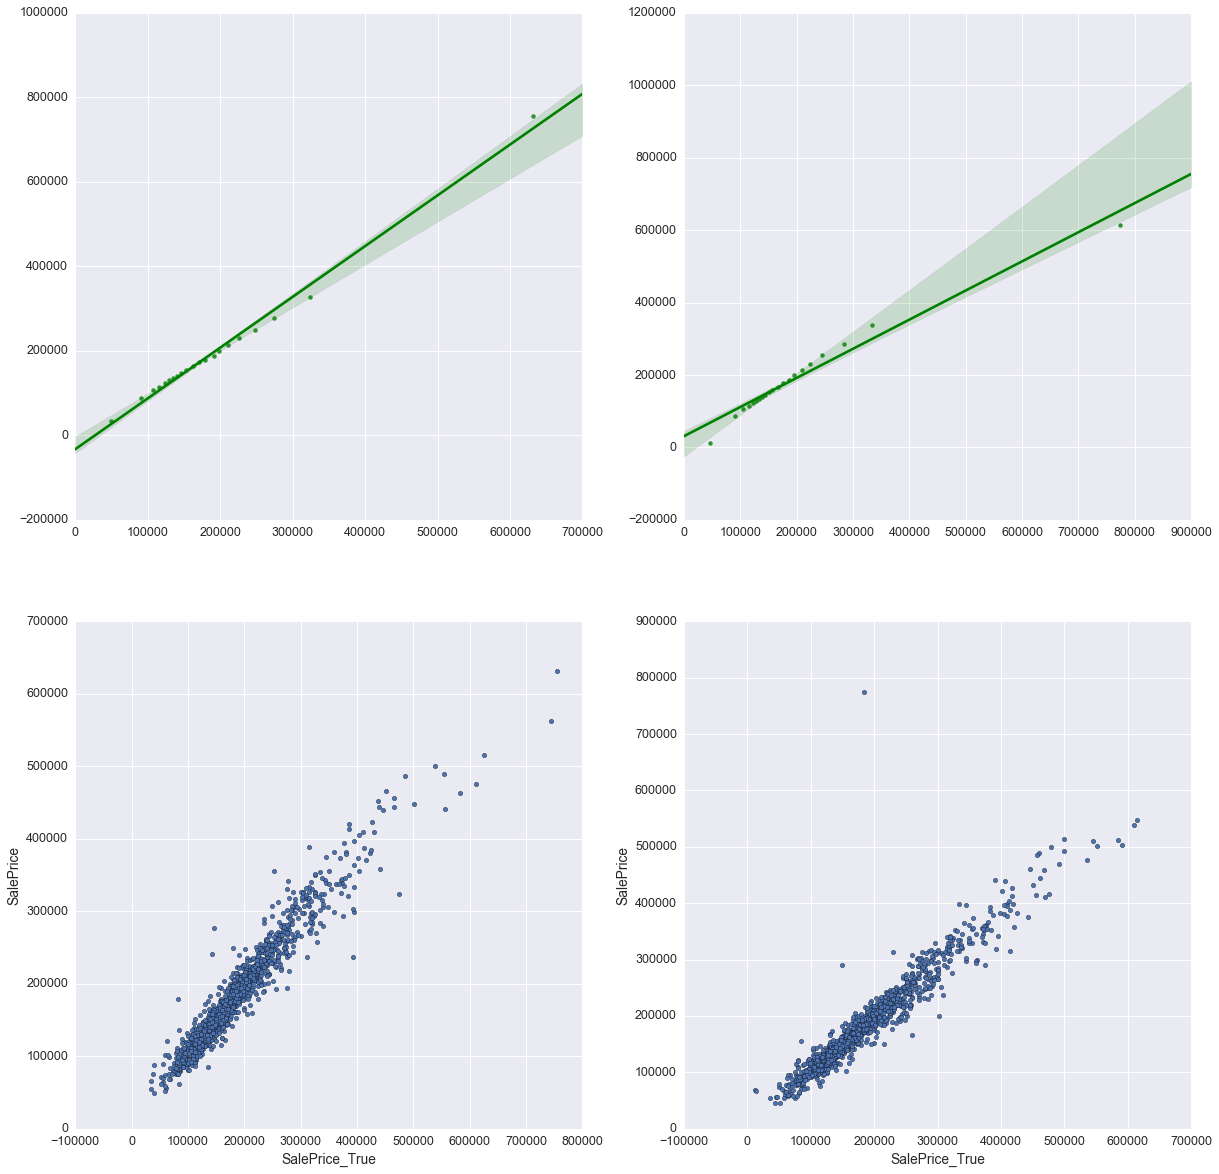

In [103]:
percs = np.linspace(0,100,21)
qn_x_test = np.percentile(test_result.SalePrice, percs)
qn_y_test = np.percentile(test_result.SalePrice_True, percs)

qn_x_train = np.percentile(train_result.SalePrice, percs)
qn_y_train = np.percentile(train_result.SalePrice_True, percs)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[20,20])


sns.regplot(x=qn_x_train, y=qn_y_train, color="g",ax=axes[0][0])
sns.regplot(x=qn_x_test, y=qn_y_test, color="g",ax=axes[0][1])

train_result.plot.scatter(x='SalePrice_True',y='SalePrice',ax=axes[1][0])
test_result.plot.scatter(x='SalePrice_True',y='SalePrice',ax=axes[1][1])

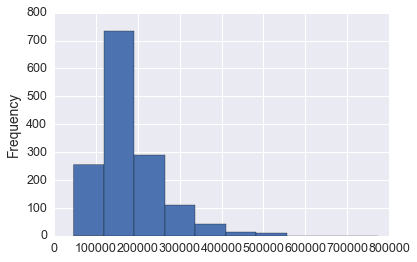

In [104]:
test_result['SalePrice'].plot.hist()

In [105]:
test_result[test_result['SalePrice'] > 500000]

,SalePrice,SalePrice_True,error,error_ratio
Id,,,,
1480,514170.185,500000,0.027946,0.026346
1664,538034.028,610000,0.125537,0.118349
1678,502125.714,552000,0.094697,0.089275
1975,547110.043,615000,0.116972,0.110274
2264,504080.138,591587,0.160073,0.150907
2550,774305.322,183850,1.437842,1.355510
2629,509882.834,545224,0.067016,0.063178
2683,511825.032,584500,0.132774,0.125171


In [106]:
test_source.loc[test_source['Id']==2550]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,_source
1089,2550,20,RL,128,39290,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,Stone,1224,Ex,TA,PConc,Ex,TA,Gd,GLQ,4010,Unf,0,1085,5095,GasA,Ex,Y,SBrkr,5095,0,0,5095,1,1,2,1,2,1,Ex,15,Typ,2,Gd,Attchd,2008,Fin,3,1154,TA,TA,Y,546,484,0,0,0,0,NaN,NaN,NaN,17000,10,2007,New,Partial,183850,test


In [107]:
test_result.loc[2550,['SalePrice']] = np.round(train_source.SalePrice.mean(),0)

In [108]:
test_result[test_result['SalePrice'] > 600000]
#test_result.loc[test_result.index[test_result['SalePrice'] > 500000],['SalePrice']] = test_result.loc[test_result.index[test_result['SalePrice'] > 500000],['SalePrice']]  * 1.2 

,SalePrice,SalePrice_True,error,error_ratio
Id,,,,


In [109]:
print ("stack2_model_Linear - Test error",CalculateError(test_result.SalePrice,test_result.SalePrice_True))

stack2_model_Linear - Test error 0.11647927305939368


In [110]:
test_result[test_result['SalePrice'] > 500000].sort_values(by = 'SalePrice', ascending = False)

,SalePrice,SalePrice_True,error,error_ratio
Id,,,,
1975,547110.043,615000,0.116972,0.110274
1664,538034.028,610000,0.125537,0.118349
1480,514170.185,500000,0.027946,0.026346
2683,511825.032,584500,0.132774,0.125171
2629,509882.834,545224,0.067016,0.063178
2264,504080.138,591587,0.160073,0.150907
1678,502125.714,552000,0.094697,0.089275


In [111]:
test_result.loc[test_result.index[test_result['SalePrice'] > 500000],['SalePrice']] = test_result.loc[test_result.index[test_result['SalePrice'] > 500000],['SalePrice']]  *  1.1

In [112]:
print ("stack2_model_Linear - Test error",CalculateError(test_result.SalePrice,test_result.SalePrice_True))

stack2_model_Linear - Test error 0.11629093972656213


In [113]:
test_result[test_result['SalePrice'] > 500000]

,SalePrice,SalePrice_True,error,error_ratio
Id,,,,
1480,565587.2035,500000,0.027946,0.026346
1664,591837.4308,610000,0.125537,0.118349
1678,552338.2854,552000,0.094697,0.089275
1975,601821.0473,615000,0.116972,0.110274
2264,554488.1518,591587,0.160073,0.150907
2629,560871.1174,545224,0.067016,0.063178
2683,563007.5352,584500,0.132774,0.125171


In [114]:
test_out = test
test_out.set_index(['Id'],inplace = True)

test_out['SalePrice'] = np.log1p(test_result.SalePrice)

test_out1 = test_out.loc[:,['SalePrice','OverallQual','OverallQual']]

'''
,'GrLivArea',OverallCond','LotArea','OverallQual','TotalPorchSF','LotFrontage','TotalBsmtSF',
'GarageArea','BsmtFinSF1','1stFlrSF','GarageYrBlt','YearBuilt','TotBathrooms','Functional'
'''


"\n,'GrLivArea',OverallCond','LotArea','OverallQual','TotalPorchSF','LotFrontage','TotalBsmtSF',\n'GarageArea','BsmtFinSF1','1stFlrSF','GarageYrBlt','YearBuilt','TotBathrooms','Functional'\n"

In [115]:
test_out1.head(10)

,SalePrice,OverallQual,OverallQual
Id,,,
1461,11.726412,-0.795092,-0.795092
1462,11.962434,-0.068293,-0.068293
1463,12.111045,-0.795092,-0.795092
1464,12.191985,-0.068293,-0.068293
1465,12.165619,1.385305,1.385305
1466,12.066016,-0.068293,-0.068293
1467,12.060800,-0.068293,-0.068293
1468,12.033244,-0.068293,-0.068293
1469,12.125751,0.658506,0.658506


In [116]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0).fit(test_out1)

test_out1["cluster"]= kmeans.labels_

g = test_out1.groupby('cluster')['cluster'].count().sort_values()

#print(kmeans.cluster_centers_)

print(g)

cluster
8     12
9     13
4     20
5     64
6    110
7    168
0    174
3    189
2    281
1    428
Name: cluster, dtype: int64


/Users/gniemiec/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [117]:
c = test_out1[test_out1["cluster"] == 8]

In [118]:
c.index.values
test_result.loc[c.index.values,:].sort_values(by = 'error_ratio', ascending = False)

,SalePrice,SalePrice_True,error,error_ratio
Id,,,,
1537,68281.220,12789,1.674986,1.579075
2217,67348.254,13100,1.637203,1.543456
2872,55189.870,35000,0.455421,0.429343
1601,63920.537,82000,0.249075,0.234813
2106,69692.385,55000,0.236754,0.223197
1815,55361.529,45000,0.207218,0.195353
2099,55483.123,46500,0.176623,0.166510
1916,66326.515,57625,0.140631,0.132578
2905,92293.690,81500,0.124371,0.117250


In [119]:
test_source[test_source["Id"].isin (c.index.values)].sort_values(by = 'SaleCondition')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,_source
76,1537,30,RM,68,9656,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,2,2,1923,1970,Gable,CompShg,AsbShng,AsbShng,None,0,TA,Fa,BrkTil,Fa,Fa,No,Unf,0,Unf,0,678,678,GasA,TA,N,SBrkr,832,0,0,832,0,0,1,0,2,1,TA,5,Typ,1,Gd,Detchd,1928,Unf,2,780,Fa,Fa,N,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Abnorml,12789,test
638,2099,20,RM,62,7311,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,1Story,2,5,1946,1950,Gable,CompShg,VinylSd,VinylSd,None,0,TA,Gd,BrkTil,TA,TA,No,Unf,0,Unf,0,407,407,GasA,TA,N,FuseA,407,0,0,407,0,0,1,0,1,1,TA,3,Typ,0,NaN,Detchd,1949,Unf,1,297,Fa,TA,Y,76,0,120,0,0,0,NaN,NaN,NaN,0,3,2008,WD,Abnorml,46500,test
756,2217,20,NaN,80,14584,Pave,NaN,Reg,Low,AllPub,Inside,Mod,IDOTRR,Norm,Norm,1Fam,1Story,1,5,1952,1952,Gable,CompShg,AsbShng,VinylSd,None,0,Fa,Po,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,Wall,Po,N,FuseA,733,0,0,733,0,0,1,0,2,1,Fa,4,NaN,0,NaN,Attchd,1952,Unf,2,487,Fa,Po,N,0,0,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Abnorml,13100,test
140,1601,30,RM,58,8154,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,5,1941,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0,TA,TA,BrkTil,TA,TA,No,BLQ,480,Unf,0,0,480,GasA,TA,Y,SBrkr,540,0,0,540,0,0,1,0,1,1,TA,4,Typ,0,NaN,Detchd,1951,Unf,1,200,Fa,Fa,N,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,ConLw,Normal,82000,test
327,1788,30,RL,90,5400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1Story,2,5,1940,1950,Gable,CompShg,Stucco,Stucco,None,0,Fa,TA,PConc,Fa,TA,No,Unf,0,Unf,0,416,416,GasA,Gd,N,FuseA,599,0,0,599,1,0,1,0,2,1,Gd,4,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,81,0,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,59000,test
354,1815,30,RM,50,5925,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,1Story,2,4,1940,1950,Gable,CompShg,MetalSd,MetalSd,None,0,TA,Gd,BrkTil,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,Fa,N,FuseA,612,0,0,612,0,0,1,0,1,1,TA,4,Typ,0,NaN,Detchd,1965,Unf,1,308,TA,Fa,N,0,0,25,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal,45000,test
387,1848,20,RL,NaN,9000,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,Norm,Norm,1Fam,1Story,2,2,1947,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0,TA,TA,Slab,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,Fa,N,SBrkr,660,0,0,660,0,0,1,0,2,1,Fa,5,Min2,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,N,0,0,100,0,0,0,NaN,NaN,NaN,0,6,2009,WD,Normal,63900,test
455,1916,30,NaN,109,21780,Grvl,NaN,Reg,Lvl,NaN,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,2,4,1910,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0,Fa,Fa,CBlock,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,TA,N,FuseA,810,0,0,810,0,0,1,0,1,1,TA,4,Min1,0,NaN,Detchd,1975,Unf,1,280,TA,TA,N,119,24,0,0,0,0,NaN,NaN,NaN,0,3,2009,ConLD,Normal,57625,test
645,2106,70,RM,60,11340,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,2Story,2,1,1920,1950,Gable,CompShg,AsbShng,AsbShng,None,0,Fa,Fa,BrkTil,Fa,Fa,No,Unf,0,Unf,0,723,723,GasA,TA,N,SBrkr,723,363,0,1086,0,0,1,0,2,1,TA,5,Maj1,0,NaN,Detchd,1920,Unf,2,400,Fa,Po,N,0,24,144,0,0,0,NaN,NaN,NaN,0,11,2008,ConLD,Normal,55000,test
1118,2579,50,RM,64,11067,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,IDOTRR,Norm,Norm,1Fam,1.5Fin,2,4,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,BrkTil,NaN,NaN,NaN,NaN,0,NaN,0,0,0,GasA,Ex,Y,SBrkr,640,0,205,845,0,0,1,0,1,1,TA,4,Maj2,0,NaN,Det

In [161]:
train_source[(train_source["OverallQual"] <= 2) & (train_source["SaleCondition"] == "Normal")].SalePrice.mode()

0    60000
dtype: int64

In [142]:
train_source[(train_source["OverallQual"] <= 2) & (train_source["SaleCondition"] == "Abnorml")].SalePrice

916    35311
Name: SalePrice, dtype: int64

In [162]:
test_result.loc[[1537,2099,2217],['SalePrice']] = 35311
test_result.loc[[1601,1788,1815,1848,1916,2106,2579,2872,2905],['SalePrice']] = 60000.0
print ("stack2_model_Linear - Test error",CalculateError(test_result.SalePrice,test_result.SalePrice_True))

stack2_model_Linear - Test error 0.10626996126509812


In [145]:
#test_source[test_source['Id'] == 1537]

In [146]:
#train_source[train_source["SalePrice"] == train_source.SalePrice.min()]

In [147]:
#test_result.loc[1537,['SalePrice']] = np.round(train_source.SalePrice.min(),0)
#print ("stack2_model_Linear - Test error",CalculateError(test_result.SalePrice,test_result.SalePrice_True))

In [148]:
#test_source[test_source['Id'] == 2217]

In [149]:
#test_result.loc[2217,['SalePrice']] = np.round(train_source.SalePrice.min(),0)
#print ("stack2_model_Linear - Test error",CalculateError(test_result.SalePrice,test_result.SalePrice_True))

In [150]:
#test_source[test_source['Id'] == 2872]

In [151]:
#train_source[(train_source["OverallQual"] == 2) & (train_source["OverallCond"] <= 3) & (train_source["YrSold"] == 2006)]

In [152]:
#test_result.loc[2872,['SalePrice']] = 35000
#print ("stack2_model_Linear - Test error",CalculateError(test_result.SalePrice,test_result.SalePrice_True))

In [153]:
test_result.to_csv('submission40.csv', index=True,columns = ['SalePrice'])

In [154]:
train_result.sort_values(by = ['error'],ascending = False).head(10)

,SalePrice,SalePrice_True,error,error_ratio
Id,,,,
31,87608.761,40000,0.783988,0.727452
633,178414.784,82500,0.771306,0.715685
969,75914.582,37900,0.694644,0.644552
463,121594.491,62383,0.667391,0.619263
1325,276863.088,147000,0.633087,0.587434
496,65449.255,34900,0.628775,0.583432
411,102141.190,60000,0.532005,0.493640
589,240474.619,143000,0.519767,0.482285
689,236659.352,392000,0.504638,0.468247


In [155]:
test_result.sort_values(by = ['error'],ascending = False).head(10)

,SalePrice,SalePrice_True,error,error_ratio
Id,,,,
1537,35311.000,12789,1.674986,1.579075
2217,35311.000,13100,1.637203,1.543456
2550,180933.000,183850,1.437842,1.355510
2040,289683.712,150000,0.658151,0.620465
1514,156207.769,84900,0.609708,0.574795
2474,79992.889,50000,0.469907,0.443000
2872,60000.000,35000,0.455421,0.429343
2152,166927.448,260000,0.443120,0.417747
2611,122625.868,80000,0.427107,0.402651


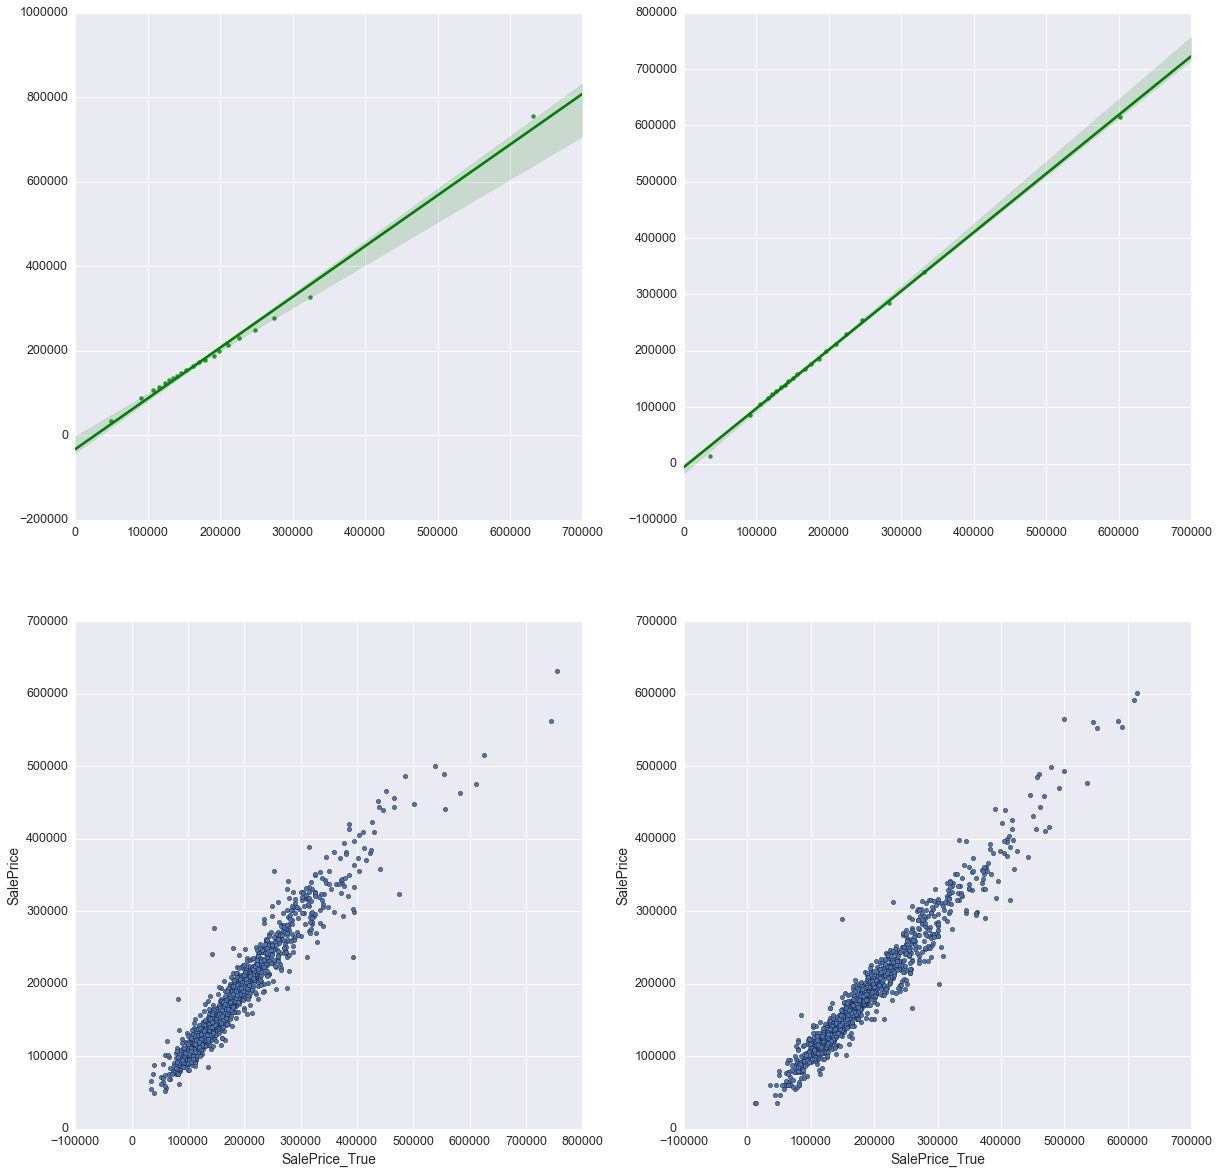

In [156]:

percs = np.linspace(0,100,21)
qn_x_test = np.percentile(test_result.SalePrice, percs)
qn_y_test = np.percentile(test_result.SalePrice_True, percs)

qn_x_train = np.percentile(train_result.SalePrice, percs)
qn_y_train = np.percentile(train_result.SalePrice_True, percs)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=[20,20])


sns.regplot(x=qn_x_train, y=qn_y_train, color="g",ax=axes[0][0])
sns.regplot(x=qn_x_test, y=qn_y_test, color="g",ax=axes[0][1])

train_result.plot.scatter(x='SalePrice_True',y='SalePrice',ax=axes[1][0])
test_result.plot.scatter(x='SalePrice_True',y='SalePrice',ax=axes[1][1])